# MOUNTING DRIVE 

In [0]:
# accés a drive

from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# IMPORTING PACKAGES

In [0]:
# imports

import numpy as np
import torch
import torchvision
import os.path as osp
from pathlib import Path
from torch.utils.data import dataset
from PIL import Image
import PIL
import os
import random
from torch import nn
from torchvision.models import vgg16_bn
from torchvision import transforms
from tqdm import tqdm_notebook

# fixant la seed
seed = 1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(seed)
random.seed(seed)
freezing=True


# CREATING DOWNLOADER CLASS

In [0]:
class Args:
  frontal_images_directories = root_path+"/dataset-cfp/Protocol/image_list_F.txt"
  profile_images_directories = root_path+"/dataset-cfp/Protocol/image_list_P.txt"
  split_main_directory = root_path+"/dataset-cfp/Protocol/Split"
  split_traindata = ["01", "02", "03", "04", "05", "06"]
  split_valdata = ["07", "08"]
  split_testdata = ["09", "10"]
  dataset_root = root_path
  dataset= "CFPDataset"

class CFPDataset(dataset.Dataset):
    def __init__(self, path, args, img_transforms=None, dataset_root="",
                 split="train", input_size=(224, 224)):
        super().__init__()

        self.data = []
        self.split = split

        self.load(path, args)

        print("Dataset loaded")
        print("{0} samples in the {1} dataset".format(len(self.data),
                                                      self.split))
        self.transforms = img_transforms
        self.dataset_root = dataset_root
        self.input_size = input_size

    def load(self, path, args):

        # read directories for frontal images
        lines = open(args.frontal_images_directories).readlines()
        idx = 0
        directories_frontal_images = []
        #print(len(lines))
        while idx < len(lines):
            x = lines[idx].strip().split()
            directories_frontal_images.append(x)
            idx += 1
        #print(x)
        # read directories for profile images
        lines = open(args.profile_images_directories).readlines()
        idx = 0
        directories_profile_images = []
        #print(len(lines))
        while idx < len(lines):
            x = lines[idx].strip().split()
            directories_profile_images.append(x)
            idx += 1
        #print(x)
        # read same and different pairs of images and save at dictionary
        self.data = []
        for i in path:
            ff_diff_file = osp.join(args.split_main_directory, 'FF', i,
                                    'diff.txt')
            lines = open(ff_diff_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('ff_diff', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_frontal_images[int(img_pair[1])-1][1]
                pair_tag = 0.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

            ff_same_file = osp.join(args.split_main_directory, 'FF', i,
                                    'same.txt')
            lines = open(ff_same_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('ff_same', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_frontal_images[int(img_pair[1])-1][1]
                pair_tag = 1.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

            fp_diff_file = osp.join(args.split_main_directory, 'FP', i,
                                    'diff.txt')
            lines = open(fp_diff_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('fp_diff', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_profile_images[int(img_pair[1])-1][1]
                pair_tag = 0.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

            fp_same_file = osp.join(args.split_main_directory, 'FP', i,
                                    'same.txt')
            lines = open(fp_same_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('ff_same', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_profile_images[int(img_pair[1])-1][1]
                pair_tag = 1.0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                self.data.append(d)
                idx += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data[index]
        image1_path = osp.join(self.dataset_root, 'dataset-cfp', d[
            'img1_path'])
        image2_path = osp.join(self.dataset_root, 'dataset-cfp', d[
            'img2_path'])
        image1 = Image.open(image1_path).convert('RGB')
        image2 = Image.open(image2_path).convert('RGB')
        tag = d['pair_tag']
        if self.transforms is not None:
            # this converts from (HxWxC) to (CxHxW) as wel
            img1 = self.transforms(image1)
            img2 = self. transforms(image2)

        return img1, img2, tag

# CREATING SIAMESE NETWORKS (VGG WITH DIFFERENT OPTIONS)

PARAMETERS: PRETRAINED, LINEAR, CLASSIFICATION

In [0]:
class SiameseDecision(nn.Module):
    """
    Siamese network
    """
    def __init__(self, pretrained=False):
        super(SiameseDecision, self).__init__()

        self.feat = vgg16_bn(pretrained=pretrained).features
        self.decision_network = nn.Sequential(
            nn.Linear(in_features=512*7*7*2, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=2)
        )

    def forward(self, img1, img2):
        feat_1 = self.feat(img1).view(img1.size(0),-1)
        
        feat_2 = self.feat(img2).view(img2.size(0),-1)
        
        feat = torch.cat((feat_1, feat_2), 1)

      
        return self.decision_network(feat)

In [0]:
class SiameseLinearDecision(nn.Module):
    """
    Siamese network
    """
    def __init__(self, pretrained=False):
        super(SiameseLinearDecision, self).__init__()

        self.feat_conv = vgg16_bn(pretrained=pretrained).features
        self.feat_linear = nn.Linear(in_features=512*7*7, out_features=4096)
        self.decision_network = nn.Sequential(
            nn.Linear(in_features=4096*2, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=2)
        )

    def forward(self, img1, img2):
        feat_1 = self.feat_conv(img1).view(img1.size(0),-1)
        
        feat_1 = self.feat_linear(feat_1)
        
        feat_2 = self.feat_conv(img2).view(img2.size(0),-1)
        feat_2 = self.feat_linear(feat_2)

        feat = torch.cat((feat_1, feat_2), 1)
      
        return self.decision_network(feat)

# UTILITIES FOR METRICS OF OUR MODELS

**ACCURACY, LOSS, TRAIN, TEST**

In [0]:
def accuracy(output, target, topk=(1,)):
    """ accuracy using pytorch functionalities
    """
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t() # transpose
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, count=1):
        self.val = val
        self.sum += val*count
        self.count += count
        self.avg = self.sum / self.count

# LOOP FOR TRAINING

**TRAINING STEP**

In [0]:
def train(model, loader, loss_criterion, optimizer):
    model.train()
    loader = tqdm_notebook(loader, desc='MiniBatch: ')
    acc = AverageMeter()
    losses = AverageMeter()
    optimizer.zero_grad()

    for i, (img1, img2, gt) in enumerate(loader, start = 0):

        img1 =  img1.to('cuda:0')
        img2 = img2.to('cuda:0')
        gt = gt.long().to('cuda:0')
        
    
        outputs = model(img1, img2)

        loss = loss_criterion(outputs, gt)
        loss.backward()
        batch_size = img1.size(0)
        losses.update(loss.item(), batch_size)
        acc.update(accuracy(outputs.data, gt)[0], batch_size)


        optimizer.step()
        optimizer.zero_grad()

        torch.cuda.empty_cache() 
        
    return losses.avg, acc.avg.item()

# LOOP FOR VALIDATION

**VALIDATION STEP**

In [0]:
def val(model, loader, loss_criterion):
    model.eval()
    loader = tqdm_notebook(loader, desc='MiniBatch: ') #Sara: Això es per veure una barra de progrès? Exacte
    acc = AverageMeter()
    losses = AverageMeter()

    with torch.no_grad():
      for i, (img1, img2, gt) in enumerate(loader, start = 0):

            img1 =  img1.to('cuda:0')
            img2 = img2.to('cuda:0')
            gt = gt.long().to('cuda:0')
            
            batch_size = img1.size(0)

            outputs = model(img1, img2)

            loss = loss_criterion(outputs, gt)

            losses.update(loss.item(), batch_size)

            acc.update(accuracy(outputs.data, gt)[0], batch_size)

            torch.cuda.empty_cache()
            
    return losses.avg, acc.avg.item()

# TEST 1: LR=1E-3, WD=0, N_EPOCHS=60 SIAMESE DECISION WITHOUT DATA AUGMENTATION

**1ST TUNING: LR=1E-3, WD=0, N_EPOCHS=60 SIAMESE DECISION WITHOUT DATA AUGMENTATION**

In [0]:
pretrained = True # Si ho poseu a false, entrenareu amb la xarxa init de forma random (Podeu fer l'experiment si voleu)
n_epochs = 60 # Número de epoques que voleu utilitzar

lr = 1e-3 # Podeu provar també amb 5e-4
betas = (0.9, 0.999) # No toqueu aquest paràmetre

wd = 0 # podeu utiltizar també 5e-4

bz = 16 # Poseu un batch size que no us desbordi la memòria

siamese_linear = False # Si poseu aquest valor a True, agafarà el model que en els features al final te una linear: SiameseDecisionLinear
data_aug = False # Si poseu aquest valor a True, us agafarà el transform amb data aumentation(podeu posar més transformacions si voleu jo solament he posat algunes d'exemple)


check_point_name = '/content/gdrive/My Drive/Colab Notebooks/weights/VGG PRETR1 LR1E-3 WD0 DA0/best_epoch.pth.tar' 
# aquest paràmetre l'heu de tunejar perquè no es sobreescriguin diferents experiments
# podeu posar els valors els paràmetres exemple:
# best_epoch_bz_32_wd_5e-4_lr_1e-3_nodata_aumentation
# IMPORTANT: AFEGIU AL PRINCIPI DEL NOM LA CARPETA ON VOLEU QUE ES GUARDI



**Main**

In [0]:

# transforms per train i val dataset



# creem dataset train i val amb els seus respectius loaders
#datasetTrain = torchvision.datasets.CIFAR10('./cifar10/train', train=True, download=True, transform=transform)
args = Args()
train_transform=None
if data_aug == False:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

else:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.RandomHorizontalFlip(), 
                                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR), 
                                        transforms.ToTensor()])

    

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

datasetTrain = CFPDataset(args.split_traindata, args, split="train", img_transforms=train_transform, dataset_root=osp.expanduser(args.dataset_root))

datasetVal= CFPDataset(args.split_valdata, args, split="val", img_transforms=val_transform, dataset_root=osp.expanduser(args.dataset_root))                          
                         

trainloader = torch.utils.data.DataLoader(datasetTrain, batch_size=bz, shuffle=True, drop_last=True, num_workers=4)
valloader = torch.utils.data.DataLoader(datasetVal, batch_size=bz,shuffle=False, num_workers=4)


# creem la xarxa
if siamese_linear == False:
  print('SiameseDecision')
  model = SiameseDecision(pretrained=pretrained)
else:
  print('SiameseLinearDecision')
  model = SiameseLinearDecision(pretrained=pretrained)
  
model = model.to('cuda:0')

# creem la loss
loss_criterion = nn.CrossEntropyLoss()

# creem el optimitzador
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)



all_train_loss = []
all_train_acc = []


all_val_loss = []
all_val_acc = []

best_acc = -1
best_epoch = 0


for epoch in tqdm_notebook(range(n_epochs), desc='Epoch: '):  
  
    train_loss, train_acc, = train(model, trainloader, loss_criterion, optimizer)
    
    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)

                    
    print("Train Epoch: ",epoch, " Loss: ",train_loss, " Acc: ", train_acc)

    val_loss, val_acc = val(model, valloader, loss_criterion)
    
    
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)

    if best_acc < val_acc:
      best_acc = val_acc
      best_epoch = epoch
      
      checkpoint = {
          'epoch' : epoch,
          'model' : model.state_dict(),
          'acc' : best_acc,
      }
      torch.save(checkpoint, check_point_name) 
               
    print("Val Epoch: ",epoch, " Loss: ",val_loss, " Acc: ", val_acc)
    
    del val_loss, val_acc, train_loss, train_acc
    
print("Best Epoch: ",best_epoch, "Best Acc: ", best_acc)

Dataset loaded
8400 samples in the train dataset
Dataset loaded
2800 samples in the val dataset
SiameseDecision


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:08<00:00, 61590278.27it/s]


Train Epoch:  0  Loss:  0.7470337921097165  Acc:  50.261905670166016


Val Epoch:  0  Loss:  0.6933674659047808  Acc:  50.0


Train Epoch:  1  Loss:  0.7198752074014573  Acc:  50.14285659790039


Val Epoch:  1  Loss:  0.6932200353486198  Acc:  50.0


Train Epoch:  2  Loss:  0.7036370843932742  Acc:  50.761905670166016


Val Epoch:  2  Loss:  0.7139731083597456  Acc:  50.42856979370117


Train Epoch:  3  Loss:  0.7178284505435398  Acc:  49.488094329833984


Val Epoch:  3  Loss:  0.693839361327035  Acc:  50.0


Train Epoch:  4  Loss:  0.6939464651970636  Acc:  50.30952453613281


Val Epoch:  4  Loss:  0.6935487352098737  Acc:  50.0


Train Epoch:  5  Loss:  0.6934616793904985  Acc:  50.07142639160156


Val Epoch:  5  Loss:  0.6931508343560355  Acc:  49.89285659790039


Train Epoch:  6  Loss:  0.693785548210144  Acc:  49.9523811340332


Val Epoch:  6  Loss:  0.6945155736378261  Acc:  50.0


Train Epoch:  7  Loss:  0.694354316847665  Acc:  49.94047546386719


Val Epoch:  7  Loss:  0.6933461880683899  Acc:  48.96428680419922


Train Epoch:  8  Loss:  0.6940429503577096  Acc:  48.85714340209961


Val Epoch:  8  Loss:  0.6937472139086042  Acc:  51.57142639160156


Train Epoch:  9  Loss:  0.6937997684024629  Acc:  50.21428680419922


Val Epoch:  9  Loss:  0.6931935024261474  Acc:  49.92856979370117


Train Epoch:  10  Loss:  0.6936371352559044  Acc:  49.69047546386719


Val Epoch:  10  Loss:  0.693957005228315  Acc:  50.0


Train Epoch:  11  Loss:  0.6936518710000175  Acc:  49.761905670166016


Val Epoch:  11  Loss:  0.6932369872501918  Acc:  50.0


Train Epoch:  12  Loss:  0.6931369308062962  Acc:  51.2023811340332


Val Epoch:  12  Loss:  0.6940720507076809  Acc:  50.0


Train Epoch:  13  Loss:  0.6936129272551763  Acc:  50.39285659790039


Val Epoch:  13  Loss:  0.6932407798085893  Acc:  50.0


Train Epoch:  14  Loss:  0.7036368238925934  Acc:  51.2023811340332


Val Epoch:  14  Loss:  3.051126857783113  Acc:  50.92856979370117


Train Epoch:  15  Loss:  0.7840927403313773  Acc:  50.64285659790039


Val Epoch:  15  Loss:  0.7595432889461518  Acc:  51.0


Train Epoch:  16  Loss:  0.7013786135401044  Acc:  50.89285659790039


Val Epoch:  16  Loss:  0.6956222472872053  Acc:  49.39285659790039


Train Epoch:  17  Loss:  0.6945818323180789  Acc:  50.03571319580078


Val Epoch:  17  Loss:  0.6908449881417411  Acc:  53.46428680419922


Train Epoch:  18  Loss:  0.6915682218188332  Acc:  52.36904525756836


Val Epoch:  18  Loss:  0.6904269136701311  Acc:  53.96428680419922


Train Epoch:  19  Loss:  0.6862348549706595  Acc:  55.25


Val Epoch:  19  Loss:  0.683572747026171  Acc:  55.89285659790039


Train Epoch:  20  Loss:  0.680840146995726  Acc:  56.11904525756836


Val Epoch:  20  Loss:  0.6875011818749565  Acc:  56.42856979370117


Train Epoch:  21  Loss:  0.6712443994340442  Acc:  58.845237731933594


Val Epoch:  21  Loss:  0.6864582923480442  Acc:  54.89285659790039


Train Epoch:  22  Loss:  0.6566666336286635  Acc:  60.80952453613281


Val Epoch:  22  Loss:  0.6314460551738739  Acc:  64.0


Train Epoch:  23  Loss:  0.6049992212795076  Acc:  66.28571319580078


Val Epoch:  23  Loss:  0.6288876712322236  Acc:  63.60714340209961


Train Epoch:  24  Loss:  0.574720541636149  Acc:  69.4047622680664


Val Epoch:  24  Loss:  0.5891768594299044  Acc:  67.89285278320312


Train Epoch:  25  Loss:  0.5601393720081874  Acc:  70.21428680419922


Val Epoch:  25  Loss:  0.5563972749028887  Acc:  70.82142639160156


Train Epoch:  26  Loss:  0.5487591590200152  Acc:  71.0


Val Epoch:  26  Loss:  0.5560295583520617  Acc:  70.92857360839844


Train Epoch:  27  Loss:  0.5334843441418239  Acc:  72.33333587646484


Val Epoch:  27  Loss:  0.5539038838659014  Acc:  71.42857360839844


Train Epoch:  28  Loss:  0.5288788588841756  Acc:  73.25


Val Epoch:  28  Loss:  0.5329617362362998  Acc:  72.89285278320312


Train Epoch:  29  Loss:  0.5146690203462329  Acc:  74.02381134033203


Val Epoch:  29  Loss:  0.5323600819281169  Acc:  72.96428680419922


Train Epoch:  30  Loss:  0.5041508056436266  Acc:  74.78571319580078


Val Epoch:  30  Loss:  0.5329687138114657  Acc:  73.10713958740234


Train Epoch:  31  Loss:  0.4972256705874488  Acc:  75.13095092773438


Val Epoch:  31  Loss:  0.5327444406918117  Acc:  72.92857360839844


Train Epoch:  32  Loss:  0.4864315773191906  Acc:  76.25


Val Epoch:  32  Loss:  0.5273257201058524  Acc:  73.85713958740234


Train Epoch:  33  Loss:  0.48004114548365273  Acc:  76.60713958740234


Val Epoch:  33  Loss:  0.5209856232575008  Acc:  74.03571319580078


Train Epoch:  34  Loss:  0.46779594012669157  Acc:  77.23809814453125


Val Epoch:  34  Loss:  0.5217435967070716  Acc:  74.46428680419922


Train Epoch:  35  Loss:  0.46314532342411224  Acc:  77.82142639160156


Val Epoch:  35  Loss:  0.5172113937991006  Acc:  74.10713958740234


Train Epoch:  36  Loss:  0.4481018204348428  Acc:  78.79761505126953


Val Epoch:  36  Loss:  0.5272357273953302  Acc:  73.64285278320312


Train Epoch:  37  Loss:  0.4349498348860514  Acc:  79.78571319580078


Val Epoch:  37  Loss:  0.5240089992114476  Acc:  74.32142639160156


Train Epoch:  38  Loss:  0.4289581445569084  Acc:  80.17857360839844


Val Epoch:  38  Loss:  0.5439307917867388  Acc:  73.78571319580078


Train Epoch:  39  Loss:  0.41563051658017297  Acc:  80.70237731933594


Val Epoch:  39  Loss:  0.5254279099191939  Acc:  75.53571319580078


Train Epoch:  40  Loss:  0.40590801678952715  Acc:  81.19047546386719


Val Epoch:  40  Loss:  0.5408913607256753  Acc:  75.03571319580078


Train Epoch:  41  Loss:  0.3949543304954256  Acc:  82.0952377319336


Val Epoch:  41  Loss:  0.5380569923775537  Acc:  75.10713958740234


Train Epoch:  42  Loss:  0.38717737351145065  Acc:  82.80952453613281


Val Epoch:  42  Loss:  0.5251721261654582  Acc:  75.75


Train Epoch:  43  Loss:  0.3773986182326362  Acc:  83.26190185546875


Val Epoch:  43  Loss:  0.5297878626414708  Acc:  74.60713958740234


Train Epoch:  44  Loss:  0.3677136523666836  Acc:  83.73809814453125


Val Epoch:  44  Loss:  0.5263695717709405  Acc:  74.07142639160156


Train Epoch:  45  Loss:  0.35774301341601783  Acc:  84.03571319580078


Val Epoch:  45  Loss:  0.5439141395688057  Acc:  75.85713958740234


Train Epoch:  46  Loss:  0.3508830852096989  Acc:  84.35713958740234


Val Epoch:  46  Loss:  0.5567315753868648  Acc:  75.89285278320312


Train Epoch:  47  Loss:  0.3427242183117639  Acc:  85.22618865966797


Val Epoch:  47  Loss:  0.5473709344863892  Acc:  76.17857360839844


Train Epoch:  48  Loss:  0.33828803205773944  Acc:  85.30952453613281


Val Epoch:  48  Loss:  0.5579238824333463  Acc:  76.10713958740234


Train Epoch:  49  Loss:  0.32701140325693856  Acc:  86.01190185546875


Val Epoch:  49  Loss:  0.5261401144521577  Acc:  76.78571319580078


Train Epoch:  50  Loss:  0.31492476255411195  Acc:  86.88095092773438


Val Epoch:  50  Loss:  0.5295073893666268  Acc:  76.89285278320312


Train Epoch:  51  Loss:  0.30765534460544586  Acc:  86.9047622680664


Val Epoch:  51  Loss:  0.6154609999486378  Acc:  77.07142639160156


Train Epoch:  52  Loss:  0.3108388290447848  Acc:  86.79761505126953


Val Epoch:  52  Loss:  0.5827231811625617  Acc:  76.42857360839844


Train Epoch:  53  Loss:  0.28689840203949385  Acc:  88.10713958740234


Val Epoch:  53  Loss:  0.6327996729101454  Acc:  76.5


Train Epoch:  54  Loss:  0.2795942554161662  Acc:  88.46428680419922


Val Epoch:  54  Loss:  0.6047184773853846  Acc:  77.28571319580078


Train Epoch:  55  Loss:  0.2817738988782678  Acc:  88.0952377319336


Val Epoch:  55  Loss:  0.6279701087943145  Acc:  75.92857360839844


Train Epoch:  56  Loss:  0.2651035149395466  Acc:  89.13095092773438


Val Epoch:  56  Loss:  0.7314893494120666  Acc:  75.89285278320312


Train Epoch:  57  Loss:  0.2592052289630686  Acc:  89.38095092773438


Val Epoch:  57  Loss:  0.6738278252524988  Acc:  76.64285278320312


Train Epoch:  58  Loss:  0.2513993396929332  Acc:  90.25


Val Epoch:  58  Loss:  0.6924070963263511  Acc:  76.17857360839844


Train Epoch:  59  Loss:  0.2439217648052034  Acc:  90.04761505126953


Val Epoch:  59  Loss:  0.6314205597553935  Acc:  76.28571319580078

Best Epoch:  54 Best Acc:  77.28571319580078


**Plot metrics**

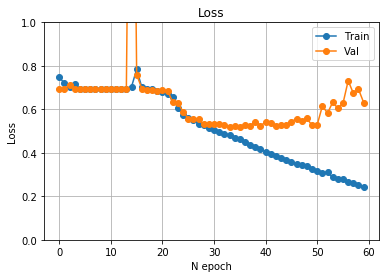

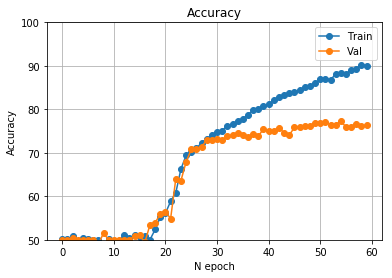

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False

plt.figure()
plt.ylim((0, 1))  
plt.plot(all_train_loss,marker='o', label="Train")
plt.plot(all_val_loss,marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend();

plt.figure()
plt.ylim((50, 100)) 
plt.plot(all_train_acc, marker='o', label="Train")
plt.plot(all_val_acc, marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)
plt.legend();
plt.show()



```
# Tiene formato de código
```

**CHECK RESULTS FOR TEST**

In [0]:
#bucle test
def test(model, loader):
    model.eval()
    loader = tqdm_notebook(loader, desc='MiniBatch: ')
    acc = AverageMeter()

    with torch.no_grad():
      for i, (img1, img2, gt) in enumerate(loader, start = 0):

            img1 =  img1.to('cuda:0')
            img2 = img2.to('cuda:0')
            gt = gt.long().to('cuda:0')
            
            batch_size = img1.size(0)

            outputs = model(img1, img2)

            acc.update(accuracy(outputs.data, gt)[0], batch_size)
 
            torch.cuda.empty_cache()
            
    return acc.avg


In [0]:
# cargamos el checkpoint con los mejores resultados en el modelo

checkpoint = torch.load(check_point_name)


model.load_state_dict(checkpoint['model'])

# creamos dataset test
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
# esta petant el dataloader amb el dataset de TEST!! Us he posat el de validació per a que vegeu que el codi funciona però.. HEU D'ARREGLAR EL DATASET DE TEST, PQ AQUEST CODI HA DE FER SERVIR EL DATASET COMENTAT (EL DE TEST) 
datasetTest= CFPDataset(args.split_testdata, args, split="test", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
#datasetTest= CFPDataset(args.split_valdata, args, split="val", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
testloader = torch.utils.data.DataLoader(datasetTest, batch_size=bz ,shuffle=False, num_workers=4)

acc = test(model, testloader)

print("Test Accuracy: ", acc.item())

Dataset loaded
2800 samples in the test dataset



Test Accuracy:  76.21428680419922


#TEST 2: LR=1E-3, WD=0, N_EPOCHS=60 SIAMESE DECISION WITH DATA AUGMENTATION

1ST TUNING: LR=1E-3, WD=0, N_EPOCHS=60 SIAMESE DECISION WITH DATA AUGMENTATION

In [0]:
pretrained = True # Si ho poseu a false, entrenareu amb la xarxa init de forma random (Podeu fer l'experiment si voleu)
n_epochs = 60 # Número de epoques que voleu utilitzar

lr = 1e-3 # Podeu provar també amb 5e-4
betas = (0.9, 0.999) # No toqueu aquest paràmetre

wd = 0 # podeu utiltizar també 5e-4

bz = 16 # Poseu un batch size que no us desbordi la memòria

siamese_linear = False # Si poseu aquest valor a True, agafarà el model que en els features al final te una linear: SiameseDecisionLinear
data_aug = True # Si poseu aquest valor a True, us agafarà el transform amb data aumentation(podeu posar més transformacions si voleu jo solament he posat algunes d'exemple)


check_point_name = '/content/gdrive/My Drive/Colab Notebooks/weights/VGG PRETR1 LR1E-3 WD0 DA1/best_epoch.pth.tar' 
# aquest paràmetre l'heu de tunejar perquè no es sobreescriguin diferents experiments
# podeu posar els valors els paràmetres exemple:
# best_epoch_bz_32_wd_5e-4_lr_1e-3_nodata_aumentation
# IMPORTANT: AFEGIU AL PRINCIPI DEL NOM LA CARPETA ON VOLEU QUE ES GUARDI

Main

In [0]:
# transforms per train i val dataset



# creem dataset train i val amb els seus respectius loaders
#datasetTrain = torchvision.datasets.CIFAR10('./cifar10/train', train=True, download=True, transform=transform)
args = Args()
train_transform=None
if data_aug == False:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

else:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.RandomHorizontalFlip(), 
                                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR), 
                                        transforms.ToTensor()])

    

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

datasetTrain = CFPDataset(args.split_traindata, args, split="train", img_transforms=train_transform, dataset_root=osp.expanduser(args.dataset_root))

datasetVal= CFPDataset(args.split_valdata, args, split="val", img_transforms=val_transform, dataset_root=osp.expanduser(args.dataset_root))                          
                         

trainloader = torch.utils.data.DataLoader(datasetTrain, batch_size=bz, shuffle=True, drop_last=True, num_workers=4)
valloader = torch.utils.data.DataLoader(datasetVal, batch_size=bz,shuffle=False, num_workers=4)


# creem la xarxa
if siamese_linear == False:
  print('SiameseDecision')
  model = SiameseDecision(pretrained=pretrained)
else:
  print('SiameseLinearDecision')
  model = SiameseLinearDecision(pretrained=pretrained)
  
model = model.to('cuda:0')

# creem la loss
loss_criterion = nn.CrossEntropyLoss()

# creem el optimitzador
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)



all_train_loss = []
all_train_acc = []


all_val_loss = []
all_val_acc = []

best_acc = -1
best_epoch = 0


for epoch in tqdm_notebook(range(n_epochs), desc='Epoch: '):  
  
    train_loss, train_acc, = train(model, trainloader, loss_criterion, optimizer)
    
    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)

                    
    print("Train Epoch: ",epoch, " Loss: ",train_loss, " Acc: ", train_acc)

    val_loss, val_acc = val(model, valloader, loss_criterion)
    
    
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)

    if best_acc < val_acc:
      best_acc = val_acc
      best_epoch = epoch
      
      checkpoint = {
          'epoch' : epoch,
          'model' : model.state_dict(),
          'acc' : best_acc,
      }
      torch.save(checkpoint, check_point_name) 
               
    print("Val Epoch: ",epoch, " Loss: ",val_loss, " Acc: ", val_acc)
    
    del val_loss, val_acc, train_loss, train_acc
    
print("Best Epoch: ",best_epoch, "Best Acc: ", best_acc)



Dataset loaded
8400 samples in the train dataset
Dataset loaded
2800 samples in the val dataset
SiameseDecision


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:07<00:00, 70598553.52it/s]


Train Epoch:  0  Loss:  0.7808226283391316  Acc:  49.85714340209961


Val Epoch:  0  Loss:  0.6949890412603106  Acc:  50.0


Train Epoch:  1  Loss:  0.6936574509030297  Acc:  49.7023811340332


Val Epoch:  1  Loss:  0.6934772729873657  Acc:  50.0


Train Epoch:  2  Loss:  0.6933859948884873  Acc:  50.47618865966797


Val Epoch:  2  Loss:  0.6933892369270325  Acc:  50.0


Train Epoch:  3  Loss:  0.693535262403034  Acc:  49.238094329833984


Val Epoch:  3  Loss:  0.6933094559397016  Acc:  50.0


Train Epoch:  4  Loss:  0.6935715688977923  Acc:  49.44047546386719


Val Epoch:  4  Loss:  0.6933053731918335  Acc:  50.0


Train Epoch:  5  Loss:  0.6932249016988845  Acc:  50.345237731933594


Val Epoch:  5  Loss:  0.6932074420792715  Acc:  50.0


Train Epoch:  6  Loss:  0.6932645352681478  Acc:  50.19047546386719


Val Epoch:  6  Loss:  0.6932815909385681  Acc:  50.0


Train Epoch:  7  Loss:  0.6933524228277661  Acc:  50.4523811340332


Val Epoch:  7  Loss:  0.693170428276062  Acc:  50.0


Train Epoch:  8  Loss:  0.693451676482246  Acc:  49.80952453613281


Val Epoch:  8  Loss:  0.6931598782539368  Acc:  50.0


Train Epoch:  9  Loss:  0.6932179841541108  Acc:  49.988094329833984


Val Epoch:  9  Loss:  0.6931490898132324  Acc:  50.0


Train Epoch:  10  Loss:  0.6935381745156788  Acc:  50.630950927734375


Val Epoch:  10  Loss:  0.6937320828437805  Acc:  50.0


Train Epoch:  11  Loss:  0.6936368603933425  Acc:  49.55952453613281


Val Epoch:  11  Loss:  0.6932143865312849  Acc:  50.0


Train Epoch:  12  Loss:  0.6940662706465949  Acc:  50.630950927734375


Val Epoch:  12  Loss:  0.6942805940764291  Acc:  50.0


Train Epoch:  13  Loss:  0.8352566787742433  Acc:  50.095237731933594


Val Epoch:  13  Loss:  1.8984266999789647  Acc:  51.89285659790039


Train Epoch:  14  Loss:  0.7671951530093238  Acc:  51.05952453613281


Val Epoch:  14  Loss:  0.6947573331424168  Acc:  49.64285659790039


Train Epoch:  15  Loss:  0.6934152027538845  Acc:  51.42856979370117


Val Epoch:  15  Loss:  0.6879332460675921  Acc:  52.71428680419922


Train Epoch:  16  Loss:  0.688952035790398  Acc:  54.011905670166016


Val Epoch:  16  Loss:  0.6745702423368182  Acc:  57.42856979370117


Train Epoch:  17  Loss:  0.6769206584067572  Acc:  57.773807525634766


Val Epoch:  17  Loss:  0.6693046476159777  Acc:  57.46428680419922


Train Epoch:  18  Loss:  0.6556332127253215  Acc:  60.69047546386719


Val Epoch:  18  Loss:  0.6378282071862902  Acc:  63.17856979370117


Train Epoch:  19  Loss:  0.6359220569474356  Acc:  63.416664123535156


Val Epoch:  19  Loss:  0.5966310690130506  Acc:  66.10713958740234


Train Epoch:  20  Loss:  0.6086359838077  Acc:  65.36904907226562


Val Epoch:  20  Loss:  0.5842499832596098  Acc:  67.32142639160156


Train Epoch:  21  Loss:  0.596911256313324  Acc:  67.05952453613281


Val Epoch:  21  Loss:  0.5587852619375502  Acc:  69.14285278320312


Train Epoch:  22  Loss:  0.5780803526583173  Acc:  68.89285278320312


Val Epoch:  22  Loss:  0.5438892934152059  Acc:  70.89285278320312


Train Epoch:  23  Loss:  0.5689938135941823  Acc:  69.76190185546875


Val Epoch:  23  Loss:  0.5471172101157052  Acc:  71.10713958740234


Train Epoch:  24  Loss:  0.5631664605367751  Acc:  70.17857360839844


Val Epoch:  24  Loss:  0.5551163629123143  Acc:  70.32142639160156


Train Epoch:  25  Loss:  0.5648161048548562  Acc:  69.77381134033203


Val Epoch:  25  Loss:  0.5544579684734344  Acc:  70.5


Train Epoch:  26  Loss:  0.5486061244351523  Acc:  71.10713958740234


Val Epoch:  26  Loss:  0.5359044328757695  Acc:  71.64285278320312


Train Epoch:  27  Loss:  0.541794572075208  Acc:  72.5


Val Epoch:  27  Loss:  0.5241179596526282  Acc:  73.32142639160156


Train Epoch:  28  Loss:  0.5323171511150542  Acc:  72.26190185546875


Val Epoch:  28  Loss:  0.5237982961961202  Acc:  73.57142639160156


Train Epoch:  29  Loss:  0.5268434078352792  Acc:  73.25


Val Epoch:  29  Loss:  0.5278791849102292  Acc:  73.46428680419922


Train Epoch:  30  Loss:  0.5219828100999196  Acc:  73.82142639160156


Val Epoch:  30  Loss:  0.5265188107320241  Acc:  73.92857360839844


Train Epoch:  31  Loss:  0.5186981997603461  Acc:  73.5


Val Epoch:  31  Loss:  0.5324870909111841  Acc:  72.17857360839844


Train Epoch:  32  Loss:  0.5106003292401632  Acc:  74.35713958740234


Val Epoch:  32  Loss:  0.5215914102963038  Acc:  73.5


Train Epoch:  33  Loss:  0.5061270789873032  Acc:  74.78571319580078


Val Epoch:  33  Loss:  0.525961741890226  Acc:  73.75


Train Epoch:  34  Loss:  0.5047237332945779  Acc:  74.98809814453125


Val Epoch:  34  Loss:  0.527683328304972  Acc:  72.85713958740234


Train Epoch:  35  Loss:  0.5024765354394912  Acc:  75.01190185546875


Val Epoch:  35  Loss:  0.5212943580320903  Acc:  73.78571319580078


Train Epoch:  36  Loss:  0.4982721919388998  Acc:  75.9047622680664


Val Epoch:  36  Loss:  0.52376890369824  Acc:  73.5


Train Epoch:  37  Loss:  0.49077744699659803  Acc:  75.6547622680664


Val Epoch:  37  Loss:  0.5187616952827998  Acc:  73.92857360839844


Train Epoch:  38  Loss:  0.49007798898787724  Acc:  76.45237731933594


Val Epoch:  38  Loss:  0.5200057421411787  Acc:  74.32142639160156


Train Epoch:  39  Loss:  0.48318877750918976  Acc:  76.27381134033203


Val Epoch:  39  Loss:  0.5074329957791737  Acc:  75.32142639160156


Train Epoch:  40  Loss:  0.47454906653790246  Acc:  76.88095092773438


Val Epoch:  40  Loss:  0.5091705118758337  Acc:  75.64285278320312


Train Epoch:  41  Loss:  0.47030607362588245  Acc:  77.72618865966797


Val Epoch:  41  Loss:  0.5153522668566023  Acc:  74.82142639160156


Train Epoch:  42  Loss:  0.4715426141875131  Acc:  77.13095092773438


Val Epoch:  42  Loss:  0.4986789170333317  Acc:  76.0


Train Epoch:  43  Loss:  0.4644574117092859  Acc:  77.83333587646484


Val Epoch:  43  Loss:  0.5118506110566003  Acc:  75.64285278320312


Train Epoch:  44  Loss:  0.4634745188554128  Acc:  78.17857360839844


Val Epoch:  44  Loss:  0.5081011463063104  Acc:  75.46428680419922


Train Epoch:  45  Loss:  0.45202026148637137  Acc:  79.02381134033203


Val Epoch:  45  Loss:  0.5133790204354695  Acc:  76.57142639160156


Train Epoch:  46  Loss:  0.45198069487299236  Acc:  78.66666412353516


Val Epoch:  46  Loss:  0.5049733530623572  Acc:  75.96428680419922


Train Epoch:  47  Loss:  0.4462913375809079  Acc:  79.36904907226562


Val Epoch:  47  Loss:  0.5080752233948026  Acc:  77.32142639160156


Train Epoch:  48  Loss:  0.43744372401918685  Acc:  79.98809814453125


Val Epoch:  48  Loss:  0.49401879370212554  Acc:  76.82142639160156


Train Epoch:  49  Loss:  0.43563876640229  Acc:  80.05952453613281


Val Epoch:  49  Loss:  0.5044911415236337  Acc:  77.14285278320312


Train Epoch:  50  Loss:  0.4255602420227868  Acc:  80.5952377319336


Val Epoch:  50  Loss:  0.49329517500741143  Acc:  77.21428680419922


Train Epoch:  51  Loss:  0.41926443866321017  Acc:  81.60713958740234


Val Epoch:  51  Loss:  0.47673776111432487  Acc:  77.71428680419922


Train Epoch:  52  Loss:  0.42137424383844646  Acc:  80.72618865966797


Val Epoch:  52  Loss:  0.5173799388749258  Acc:  77.75


Train Epoch:  53  Loss:  0.41720448451382774  Acc:  80.92857360839844


Val Epoch:  53  Loss:  0.49502824119159156  Acc:  78.46428680419922


Train Epoch:  54  Loss:  0.4099531309661411  Acc:  81.22618865966797


Val Epoch:  54  Loss:  0.49820355385541915  Acc:  77.82142639160156


Train Epoch:  55  Loss:  0.4078729704448155  Acc:  82.0952377319336


Val Epoch:  55  Loss:  0.48745636808020726  Acc:  78.71428680419922


Train Epoch:  56  Loss:  0.40213410454136983  Acc:  81.5


Val Epoch:  56  Loss:  0.48187917892421994  Acc:  78.53571319580078


Train Epoch:  57  Loss:  0.39456089102086567  Acc:  82.44047546386719


Val Epoch:  57  Loss:  0.4915458759665489  Acc:  78.53571319580078


Train Epoch:  58  Loss:  0.3952561014606839  Acc:  82.0


Val Epoch:  58  Loss:  0.47835974141955373  Acc:  79.32142639160156


Train Epoch:  59  Loss:  0.39107563569432213  Acc:  82.41666412353516


Val Epoch:  59  Loss:  0.5094428678069796  Acc:  78.64285278320312

Best Epoch:  58 Best Acc:  79.32142639160156


Plot metrics

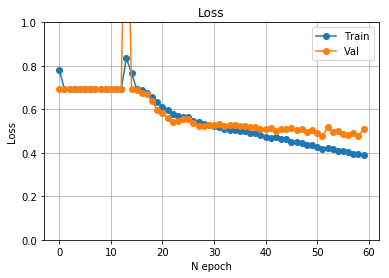

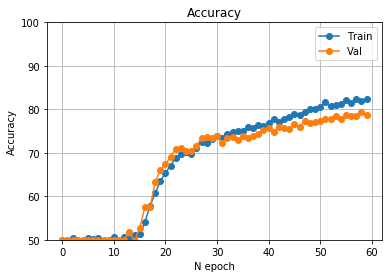

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False

plt.figure()
plt.ylim((0, 1))  
plt.plot(all_train_loss,marker='o', label="Train")
plt.plot(all_val_loss,marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend();

plt.figure()
plt.ylim((50, 100)) 
plt.plot(all_train_acc, marker='o', label="Train")
plt.plot(all_val_acc, marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)
plt.legend();
plt.show()


CHECK TEST RESULTS

In [0]:

#bucle test
def test(model, loader):
    model.eval()
    loader = tqdm_notebook(loader, desc='MiniBatch: ')
    acc = AverageMeter()

    with torch.no_grad():
      for i, (img1, img2, gt) in enumerate(loader, start = 0):

            img1 =  img1.to('cuda:0')
            img2 = img2.to('cuda:0')
            gt = gt.long().to('cuda:0')
            
            batch_size = img1.size(0)

            outputs = model(img1, img2)

            acc.update(accuracy(outputs.data, gt)[0], batch_size)

            torch.cuda.empty_cache()
            
    return acc.avg








# cargamos el checkpoint con los mejores resultados en el modelo

checkpoint = torch.load(check_point_name)


model.load_state_dict(checkpoint['model'])

# creamos dataset test
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
# esta petant el dataloader amb el dataset de TEST!! Us he posat el de validació per a que vegeu que el codi funciona però.. HEU D'ARREGLAR EL DATASET DE TEST, PQ AQUEST CODI HA DE FER SERVIR EL DATASET COMENTAT (EL DE TEST) 
datasetTest= CFPDataset(args.split_testdata, args, split="test", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
#datasetTest= CFPDataset(args.split_valdata, args, split="val", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
testloader = torch.utils.data.DataLoader(datasetTest, batch_size=bz ,shuffle=False, num_workers=4)

acc = test(model, testloader)

print("Test Accuracy: ", acc.item())

Dataset loaded
2800 samples in the test dataset



Test Accuracy:  79.92857360839844


# TEST 3: LR=5E-4, WD=0, N_EPOCHS=60 SIAMESE DECISION WITH DATA AUGMENTATION

1ST TUNING: LR=5E-4, WD=0, N_EPOCHS=60 SIAMESE DECISION WITH DATA AUGMENTATION

In [0]:
pretrained = True # Si ho poseu a false, entrenareu amb la xarxa init de forma random (Podeu fer l'experiment si voleu)
n_epochs = 60 # Número de epoques que voleu utilitzar

lr = 5e-4 # Podeu provar també amb 5e-4
betas = (0.9, 0.999) # No toqueu aquest paràmetre

wd = 0 # podeu utiltizar també 5e-4

bz = 16 # Poseu un batch size que no us desbordi la memòria

siamese_linear = False # Si poseu aquest valor a True, agafarà el model que en els features al final te una linear: SiameseDecisionLinear
data_aug = True # Si poseu aquest valor a True, us agafarà el transform amb data aumentation(podeu posar més transformacions si voleu jo solament he posat algunes d'exemple)


check_point_name = '/content/gdrive/My Drive/Colab Notebooks/weights/VGG PRETR1 LR5E-4 WD0 DA1/best_epoch.pth.tar' 
# aquest paràmetre l'heu de tunejar perquè no es sobreescriguin diferents experiments
# podeu posar els valors els paràmetres exemple:
# best_epoch_bz_32_wd_5e-4_lr_1e-3_nodata_aumentation
# IMPORTANT: AFEGIU AL PRINCIPI DEL NOM LA CARPETA ON VOLEU QUE ES GUARDI



Main

In [0]:
# transforms per train i val dataset



# creem dataset train i val amb els seus respectius loaders
#datasetTrain = torchvision.datasets.CIFAR10('./cifar10/train', train=True, download=True, transform=transform)
args = Args()
train_transform=None
if data_aug == False:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

else:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.RandomHorizontalFlip(), 
                                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR), 
                                        transforms.ToTensor()])

    

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

datasetTrain = CFPDataset(args.split_traindata, args, split="train", img_transforms=train_transform, dataset_root=osp.expanduser(args.dataset_root))

datasetVal= CFPDataset(args.split_valdata, args, split="val", img_transforms=val_transform, dataset_root=osp.expanduser(args.dataset_root))                          
                         

trainloader = torch.utils.data.DataLoader(datasetTrain, batch_size=bz, shuffle=True, drop_last=True, num_workers=4)
valloader = torch.utils.data.DataLoader(datasetVal, batch_size=bz,shuffle=False, num_workers=4)


# creem la xarxa
if siamese_linear == False:
  print('SiameseDecision')
  model = SiameseDecision(pretrained=pretrained)
else:
  print('SiameseLinearDecision')
  model = SiameseLinearDecision(pretrained=pretrained)
  
model = model.to('cuda:0')

# creem la loss
loss_criterion = nn.CrossEntropyLoss()

# creem el optimitzador
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)



all_train_loss = []
all_train_acc = []


all_val_loss = []
all_val_acc = []

best_acc = -1
best_epoch = 0


for epoch in tqdm_notebook(range(n_epochs), desc='Epoch: '):  
  
    train_loss, train_acc, = train(model, trainloader, loss_criterion, optimizer)
    
    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)

                    
    print("Train Epoch: ",epoch, " Loss: ",train_loss, " Acc: ", train_acc)

    val_loss, val_acc = val(model, valloader, loss_criterion)
    
    
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)

    if best_acc < val_acc:
      best_acc = val_acc
      best_epoch = epoch
      
      checkpoint = {
          'epoch' : epoch,
          'model' : model.state_dict(),
          'acc' : best_acc,
      }
      torch.save(checkpoint, check_point_name) 
               
    print("Val Epoch: ",epoch, " Loss: ",val_loss, " Acc: ", val_acc)
    
    del val_loss, val_acc, train_loss, train_acc
    
print("Best Epoch: ",best_epoch, "Best Acc: ", best_acc)




Dataset loaded
8400 samples in the train dataset
Dataset loaded
2800 samples in the val dataset
SiameseDecision


Train Epoch:  0  Loss:  0.7393384420871735  Acc:  54.94047546386719


Val Epoch:  0  Loss:  0.6413670023850032  Acc:  62.78571319580078


Train Epoch:  1  Loss:  0.6458440572874886  Acc:  63.28571319580078


Val Epoch:  1  Loss:  0.6131231447628566  Acc:  66.28571319580078


Train Epoch:  2  Loss:  0.6187691945121402  Acc:  66.0


Val Epoch:  2  Loss:  0.5886617640086583  Acc:  68.53571319580078


Train Epoch:  3  Loss:  0.6036959937640599  Acc:  67.03571319580078


Val Epoch:  3  Loss:  0.5948322744028909  Acc:  67.64285278320312


Train Epoch:  4  Loss:  0.5926623728161766  Acc:  67.58333587646484


Val Epoch:  4  Loss:  0.6247631936413901  Acc:  66.71428680419922


Train Epoch:  5  Loss:  0.5899390930221194  Acc:  67.5


Val Epoch:  5  Loss:  0.572456990821021  Acc:  69.57142639160156


Train Epoch:  6  Loss:  0.5805955884002504  Acc:  68.60713958740234


Val Epoch:  6  Loss:  0.5714370613438743  Acc:  69.21428680419922


Train Epoch:  7  Loss:  0.5724925251801809  Acc:  68.52381134033203


Val Epoch:  7  Loss:  0.5722242559705462  Acc:  69.57142639160156


Train Epoch:  8  Loss:  0.5680966704800016  Acc:  69.16666412353516


Val Epoch:  8  Loss:  0.5622339294637952  Acc:  69.78571319580078


Train Epoch:  9  Loss:  0.5618670266015189  Acc:  69.71428680419922


Val Epoch:  9  Loss:  0.5623882044213159  Acc:  70.10713958740234


Train Epoch:  10  Loss:  0.5600836132821583  Acc:  69.6547622680664


Val Epoch:  10  Loss:  0.5582018826689039  Acc:  70.64285278320312


Train Epoch:  11  Loss:  0.5575528042657035  Acc:  69.85713958740234


Val Epoch:  11  Loss:  0.5652604097979409  Acc:  70.07142639160156


Train Epoch:  12  Loss:  0.5567147420701526  Acc:  70.13095092773438


Val Epoch:  12  Loss:  0.5531089351858411  Acc:  70.89285278320312


Train Epoch:  13  Loss:  0.5527019416718256  Acc:  70.20237731933594


Val Epoch:  13  Loss:  0.5597908990723747  Acc:  69.96428680419922


Train Epoch:  14  Loss:  0.548225816828864  Acc:  70.32142639160156


Val Epoch:  14  Loss:  0.5488565415143967  Acc:  71.25


Train Epoch:  15  Loss:  0.5481608970392318  Acc:  70.60713958740234


Val Epoch:  15  Loss:  0.5571769102982113  Acc:  70.82142639160156


Train Epoch:  16  Loss:  0.556890324921835  Acc:  70.02381134033203


Val Epoch:  16  Loss:  0.5585629434244973  Acc:  69.96428680419922


Train Epoch:  17  Loss:  0.5475034801165263  Acc:  70.55952453613281


Val Epoch:  17  Loss:  0.5724618230547224  Acc:  69.89285278320312


Train Epoch:  18  Loss:  0.5474805733703432  Acc:  70.19047546386719


Val Epoch:  18  Loss:  0.5518615284987859  Acc:  71.03571319580078


Train Epoch:  19  Loss:  0.5436287861210959  Acc:  70.98809814453125


Val Epoch:  19  Loss:  0.5552818398816245  Acc:  70.71428680419922


Train Epoch:  20  Loss:  0.541931624838284  Acc:  70.67857360839844


Val Epoch:  20  Loss:  0.5536955618858337  Acc:  71.75


Train Epoch:  21  Loss:  0.5505735762914021  Acc:  69.82142639160156


Val Epoch:  21  Loss:  0.5527887734345027  Acc:  70.42857360839844


Train Epoch:  22  Loss:  0.5428479241757166  Acc:  70.83333587646484


Val Epoch:  22  Loss:  0.5523621157237462  Acc:  71.17857360839844


Train Epoch:  23  Loss:  0.5431687375477382  Acc:  71.05952453613281


Val Epoch:  23  Loss:  0.6449333368028913  Acc:  68.03571319580078


Train Epoch:  24  Loss:  0.5402881817590622  Acc:  71.28571319580078


Val Epoch:  24  Loss:  0.554086634516716  Acc:  70.75


Train Epoch:  25  Loss:  0.5391872457663218  Acc:  71.10713958740234


Val Epoch:  25  Loss:  0.5609807748453958  Acc:  69.71428680419922


Train Epoch:  26  Loss:  0.5386746679033552  Acc:  70.8452377319336


Val Epoch:  26  Loss:  0.5571601443631309  Acc:  70.85713958740234


Train Epoch:  27  Loss:  0.5347145179339817  Acc:  71.13095092773438


Val Epoch:  27  Loss:  0.555361459340368  Acc:  71.0


Train Epoch:  28  Loss:  0.5320927281606765  Acc:  71.67857360839844


Val Epoch:  28  Loss:  0.5551072801862444  Acc:  71.14285278320312


Train Epoch:  29  Loss:  0.5348333472581137  Acc:  71.0


Val Epoch:  29  Loss:  0.5526908553498132  Acc:  71.07142639160156


Train Epoch:  30  Loss:  0.5298888477824983  Acc:  71.5


Val Epoch:  30  Loss:  0.5478335279226303  Acc:  70.82142639160156


Train Epoch:  31  Loss:  0.5313763556310108  Acc:  71.78571319580078


Val Epoch:  31  Loss:  0.5524642408745629  Acc:  71.39285278320312


Train Epoch:  32  Loss:  0.531658053341366  Acc:  71.47618865966797


Val Epoch:  32  Loss:  0.5545586555344718  Acc:  71.21428680419922


Train Epoch:  33  Loss:  0.5267782059169951  Acc:  71.33333587646484


Val Epoch:  33  Loss:  0.5579148876667023  Acc:  71.28571319580078


Train Epoch:  34  Loss:  0.5153102315323693  Acc:  72.82142639160156


Val Epoch:  34  Loss:  0.5754381723063333  Acc:  70.25


Train Epoch:  35  Loss:  0.5296993649857384  Acc:  72.3452377319336


Val Epoch:  35  Loss:  0.5466776868275234  Acc:  73.03571319580078


Train Epoch:  36  Loss:  0.502199309070905  Acc:  75.0


Val Epoch:  36  Loss:  0.5103135167700904  Acc:  75.25


Train Epoch:  37  Loss:  0.48537527782576423  Acc:  76.08333587646484


Val Epoch:  37  Loss:  0.5156931035007749  Acc:  75.96428680419922


Train Epoch:  38  Loss:  0.4818220181124551  Acc:  76.8452377319336


Val Epoch:  38  Loss:  0.5041838169949395  Acc:  76.5


Train Epoch:  39  Loss:  0.5062105702218556  Acc:  76.03571319580078


Val Epoch:  39  Loss:  0.5227875580957958  Acc:  75.96428680419922


Train Epoch:  40  Loss:  0.4712546143077669  Acc:  78.05952453613281


Val Epoch:  40  Loss:  0.4938092769895281  Acc:  77.17857360839844


Train Epoch:  41  Loss:  0.4559943226973216  Acc:  78.79761505126953


Val Epoch:  41  Loss:  0.499025208907468  Acc:  76.53571319580078


Train Epoch:  42  Loss:  0.4548465790351232  Acc:  78.11904907226562


Val Epoch:  42  Loss:  0.4810086690528052  Acc:  78.35713958740234


Train Epoch:  43  Loss:  0.4512261053777876  Acc:  78.77381134033203


Val Epoch:  43  Loss:  0.46738733436380114  Acc:  78.39285278320312


Train Epoch:  44  Loss:  0.4357803564128422  Acc:  79.45237731933594


Val Epoch:  44  Loss:  0.4762082259995597  Acc:  78.14285278320312


Train Epoch:  45  Loss:  0.43689985014143445  Acc:  79.41666412353516


Val Epoch:  45  Loss:  0.4790722680943353  Acc:  78.14285278320312


Train Epoch:  46  Loss:  0.43295525630315146  Acc:  79.96428680419922


Val Epoch:  46  Loss:  0.464524142912456  Acc:  79.07142639160156


Train Epoch:  47  Loss:  0.42434032309622993  Acc:  80.01190185546875


Val Epoch:  47  Loss:  0.46981006383895874  Acc:  77.92857360839844


Buffered data was truncated after reaching the output size limit.

Plot metrics

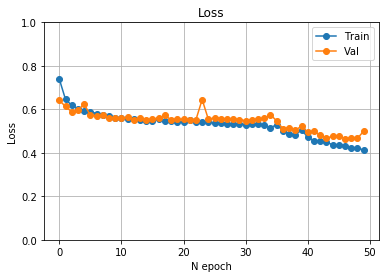

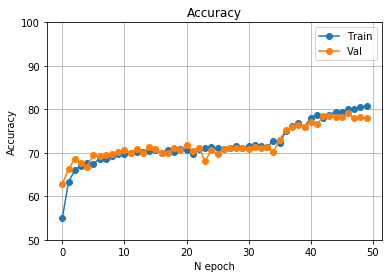

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False

plt.figure()
plt.ylim((0, 1))  
plt.plot(all_train_loss,marker='o', label="Train")
plt.plot(all_val_loss,marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend();

plt.figure()
plt.ylim((50, 100)) 
plt.plot(all_train_acc, marker='o', label="Train")
plt.plot(all_val_acc, marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)
plt.legend();
plt.show()



CHECK TEST RESULTS

In [0]:

#bucle test
def test(model, loader):
    model.eval()
    loader = tqdm_notebook(loader, desc='MiniBatch: ')
    acc = AverageMeter()

    with torch.no_grad():
      for i, (img1, img2, gt) in enumerate(loader, start = 0):

            img1 =  img1.to('cuda:0')
            img2 = img2.to('cuda:0')
            gt = gt.long().to('cuda:0')
            
            batch_size = img1.size(0)

            outputs = model(img1, img2)

            acc.update(accuracy(outputs.data, gt)[0], batch_size)

            torch.cuda.empty_cache()
            
    return acc.avg





# cargamos el checkpoint con los mejores resultados en el modelo 
checkpoint = torch.load(check_point_name)


model.load_state_dict(checkpoint['model'])

# creamos dataset test
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
# esta petant el dataloader amb el dataset de TEST!! Us he posat el de validació per a que vegeu que el codi funciona però.. HEU D'ARREGLAR EL DATASET DE TEST, PQ AQUEST CODI HA DE FER SERVIR EL DATASET COMENTAT (EL DE TEST) 
datasetTest= CFPDataset(args.split_testdata, args, split="test", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
#datasetTest= CFPDataset(args.split_valdata, args, split="val", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
testloader = torch.utils.data.DataLoader(datasetTest, batch_size=bz ,shuffle=False, num_workers=4)

acc = test(model, testloader)

print("Test Accuracy: ", acc.item())






Dataset loaded
2800 samples in the test dataset


Test Accuracy:  78.0


# TEST 4: LR=1E-3, WD=0, N_EPOCHS=60 SIAMESE DECISION WITHOUT DATA AUGMENTATION WITH FREEZE

1ST TUNING: LR=1E-3, WD=0, N_EPOCHS=60 SIAMESE DECISION WITHOUT DATA AUGMENTATION WITH FREEZE

In [0]:
pretrained = True # Si ho poseu a false, entrenareu amb la xarxa init de forma random (Podeu fer l'experiment si voleu)
n_epochs = 60 # Número de epoques que voleu utilitzar

lr = 1e-3 # Podeu provar també amb 5e-4
betas = (0.9, 0.999) # No toqueu aquest paràmetre

wd = 0 # podeu utiltizar també 5e-4

bz = 16 # Poseu un batch size que no us desbordi la memòria

freezing=True #congelem layers

siamese_linear = False # Si poseu aquest valor a True, agafarà el model que en els features al final te una linear: SiameseDecisionLinear
data_aug = True # Si poseu aquest valor a True, us agafarà el transform amb data aumentation(podeu posar més transformacions si voleu jo solament he posat algunes d'exemple)


check_point_name = '/content/gdrive/My Drive/Colab Notebooks/weights/VGG PRETR1 LR1E-3 WD0 DA1 FREEZE/best_epoch.pth.tar' 
# aquest paràmetre l'heu de tunejar perquè no es sobreescriguin diferents experiments
# podeu posar els valors els paràmetres exemple:
# best_epoch_bz_32_wd_5e-4_lr_1e-3_nodata_aumentation
# IMPORTANT: AFEGIU AL PRINCIPI DEL NOM LA CARPETA ON VOLEU QUE ES GUARDI

MAIN

In [0]:
# transforms per train i val dataset



# creem dataset train i val amb els seus respectius loaders
#datasetTrain = torchvision.datasets.CIFAR10('./cifar10/train', train=True, download=True, transform=transform)
args = Args()
train_transform=None
if data_aug == False:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

else:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.RandomHorizontalFlip(), 
                                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR), 
                                        transforms.ToTensor()])

    

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

datasetTrain = CFPDataset(args.split_traindata, args, split="train", img_transforms=train_transform, dataset_root=osp.expanduser(args.dataset_root))

datasetVal= CFPDataset(args.split_valdata, args, split="val", img_transforms=val_transform, dataset_root=osp.expanduser(args.dataset_root))                          
                         

trainloader = torch.utils.data.DataLoader(datasetTrain, batch_size=bz, shuffle=True, drop_last=True, num_workers=4)
valloader = torch.utils.data.DataLoader(datasetVal, batch_size=bz,shuffle=False, num_workers=4)


# creem la xarxa
if siamese_linear == False:
  print('SiameseDecision')
  model = SiameseDecision(pretrained=pretrained) 
else:
  print('SiameseLinearDecision')
  model = SiameseLinearDecision(pretrained=pretrained)
  
if freezing==True: 
    print("State of the features layers: \n")
    for name, child in model.feat.named_children():
      for name_2, params in child.named_parameters():
        print(child, name_2, params.requires_grad)
    nConv = 7 # Num de conv layers que queremos congelar
    features_freezed = 0
    for name, child in model.feat.named_children():
       if features_freezed < nConv:
        if isinstance(child,torch.nn.modules.conv.Conv2d): features_freezed+=1
        for name2, params in child.named_parameters():
          params.requires_grad = False

          model = model.to('cuda:0')

# creem la loss
loss_criterion = nn.CrossEntropyLoss()

# creem el optimitzador
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)



all_train_loss = []
all_train_acc = []


all_val_loss = []
all_val_acc = []

best_acc = -1
best_epoch = 0


for epoch in tqdm_notebook(range(n_epochs), desc='Epoch: '):  
  
    train_loss, train_acc, = train(model, trainloader, loss_criterion, optimizer)
    
    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)

                    
    print("Train Epoch: ",epoch, " Loss: ",train_loss, " Acc: ", train_acc)

    val_loss, val_acc = val(model, valloader, loss_criterion)
    
    
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)

    if best_acc < val_acc:
      best_acc = val_acc
      best_epoch = epoch
      
      checkpoint = {
          'epoch' : epoch,
          'model' : model.state_dict(),
          'acc' : best_acc,
      }
      torch.save(checkpoint, check_point_name) 
               
    print("Val Epoch: ",epoch, " Loss: ",val_loss, " Acc: ", val_acc)
    
    del val_loss, val_acc, train_loss, train_acc
    
print("Best Epoch: ",best_epoch, "Best Acc: ", best_acc)

Dataset loaded
8400 samples in the train dataset
Dataset loaded
2800 samples in the val dataset
SiameseDecision


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:06<00:00, 83907111.21it/s]


State of the features layers: 

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) weight True
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) bias True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) weight True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) bias True
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) weight True
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) bias True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) weight True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) bias True
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) weight True
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) bias True
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) weight True
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

Train Epoch:  0  Loss:  0.7811285784131005  Acc:  49.61904525756836


Val Epoch:  0  Loss:  0.6963601895741054  Acc:  50.0


Train Epoch:  1  Loss:  0.6938132758367629  Acc:  50.023807525634766


Val Epoch:  1  Loss:  0.6932493669646127  Acc:  50.0


Train Epoch:  2  Loss:  0.6933395397095453  Acc:  50.511905670166016


Val Epoch:  2  Loss:  0.6932344143731254  Acc:  50.0


Train Epoch:  3  Loss:  0.6935517667588733  Acc:  49.89285659790039


Val Epoch:  3  Loss:  0.6933127948216029  Acc:  50.0


Train Epoch:  4  Loss:  0.6936345092455546  Acc:  49.41666793823242


Val Epoch:  4  Loss:  0.6933651566505432  Acc:  50.0


Train Epoch:  5  Loss:  0.6934875059127807  Acc:  49.30952453613281


Val Epoch:  5  Loss:  0.6932334899902344  Acc:  50.0


Train Epoch:  6  Loss:  0.6935406983466376  Acc:  49.345237731933594


Val Epoch:  6  Loss:  0.6932327454430717  Acc:  50.0


Train Epoch:  7  Loss:  0.6934945792243594  Acc:  49.630950927734375


Val Epoch:  7  Loss:  0.6931559443473816  Acc:  50.0


Train Epoch:  8  Loss:  0.6934286524000622  Acc:  49.96428680419922


Val Epoch:  8  Loss:  0.6931725144386292  Acc:  50.0


Train Epoch:  9  Loss:  0.6930972934904552  Acc:  50.5


Val Epoch:  9  Loss:  0.6931490002359663  Acc:  50.0


Train Epoch:  10  Loss:  0.6934824036416554  Acc:  50.05952453613281


Val Epoch:  10  Loss:  0.693436323915209  Acc:  50.0


Train Epoch:  11  Loss:  0.6933482526597523  Acc:  50.08333206176758


Val Epoch:  11  Loss:  0.6931595802307129  Acc:  50.0


Train Epoch:  12  Loss:  0.6930143728710356  Acc:  50.66666793823242


Val Epoch:  12  Loss:  0.6934771827289037  Acc:  50.0


Train Epoch:  13  Loss:  0.6933949489820571  Acc:  50.4523811340332


Val Epoch:  13  Loss:  0.6933338039261954  Acc:  50.0


Train Epoch:  14  Loss:  0.6932590767315456  Acc:  50.14285659790039


Val Epoch:  14  Loss:  0.693147211756025  Acc:  50.0


Train Epoch:  15  Loss:  0.6933188043321882  Acc:  49.47618865966797


Val Epoch:  15  Loss:  0.6931666135787964  Acc:  50.0


Train Epoch:  16  Loss:  0.6932189693905059  Acc:  50.80952453613281


Val Epoch:  16  Loss:  0.6932406425476074  Acc:  50.0


Train Epoch:  17  Loss:  0.6934571181024823  Acc:  49.64285659790039


Val Epoch:  17  Loss:  0.6931487917900085  Acc:  50.0


Train Epoch:  18  Loss:  0.6934500193595886  Acc:  48.82142639160156


Val Epoch:  18  Loss:  0.6931629187720163  Acc:  50.0


Train Epoch:  19  Loss:  0.693216443288894  Acc:  50.011905670166016


Val Epoch:  19  Loss:  0.6932136416435242  Acc:  50.0


Train Epoch:  20  Loss:  0.6933586382865906  Acc:  49.72618865966797


Val Epoch:  20  Loss:  0.6931476593017578  Acc:  50.0


Train Epoch:  21  Loss:  0.6932906900133405  Acc:  49.154762268066406


Val Epoch:  21  Loss:  0.6931473313059126  Acc:  50.0


Train Epoch:  22  Loss:  0.6932806891486758  Acc:  50.17856979370117


Val Epoch:  22  Loss:  0.6931588053703308  Acc:  50.0


Train Epoch:  23  Loss:  0.6931812837010338  Acc:  50.511905670166016


Val Epoch:  23  Loss:  0.6931973702566965  Acc:  50.0


Train Epoch:  24  Loss:  0.693314509278252  Acc:  49.83333206176758


Val Epoch:  24  Loss:  0.6931635737419128  Acc:  50.0


Train Epoch:  25  Loss:  0.6932578660192944  Acc:  49.83333206176758


Val Epoch:  25  Loss:  0.693168580532074  Acc:  50.0


Train Epoch:  26  Loss:  0.6932546003659567  Acc:  48.94047546386719


Val Epoch:  26  Loss:  0.6931577621187482  Acc:  50.0


Train Epoch:  27  Loss:  0.6932816740444728  Acc:  49.21428680419922


Val Epoch:  27  Loss:  0.6931476293291364  Acc:  50.0


Train Epoch:  28  Loss:  0.6932068782760984  Acc:  50.42856979370117


Val Epoch:  28  Loss:  0.6931691459247045  Acc:  50.0


Train Epoch:  29  Loss:  0.6932921156429109  Acc:  48.72618865966797


Val Epoch:  29  Loss:  0.6931590138162885  Acc:  50.0


Train Epoch:  30  Loss:  0.6932216166314624  Acc:  50.14285659790039


Val Epoch:  30  Loss:  0.6931577624593462  Acc:  50.0


Train Epoch:  31  Loss:  0.6932444955053784  Acc:  49.16666793823242


Val Epoch:  31  Loss:  0.6931506984574454  Acc:  50.0


Train Epoch:  32  Loss:  0.6932461653436933  Acc:  50.07142639160156


Val Epoch:  32  Loss:  0.6931959690366473  Acc:  50.0


Train Epoch:  33  Loss:  0.693200424285162  Acc:  50.16666793823242


Val Epoch:  33  Loss:  0.6931808584077017  Acc:  50.0


Train Epoch:  34  Loss:  0.6932469307808649  Acc:  49.47618865966797


Val Epoch:  34  Loss:  0.6931522788320269  Acc:  50.0


Train Epoch:  35  Loss:  0.6932757508187067  Acc:  49.261905670166016


Val Epoch:  35  Loss:  0.693151593208313  Acc:  50.0


Train Epoch:  36  Loss:  0.6932371901330494  Acc:  50.57142639160156


Val Epoch:  36  Loss:  0.6932088422775269  Acc:  50.0


Train Epoch:  37  Loss:  0.693262940134321  Acc:  49.80952453613281


Val Epoch:  37  Loss:  0.6931492686271667  Acc:  50.0


Train Epoch:  38  Loss:  0.6932600775219145  Acc:  49.14285659790039


Val Epoch:  38  Loss:  0.6931478973797389  Acc:  50.0


Train Epoch:  39  Loss:  0.6932277617000399  Acc:  49.42856979370117


Val Epoch:  39  Loss:  0.6931473016738892  Acc:  50.0


Train Epoch:  40  Loss:  0.6932124951907567  Acc:  50.380950927734375


Val Epoch:  40  Loss:  0.6931994557380676  Acc:  50.0


Train Epoch:  41  Loss:  0.6932140600113642  Acc:  50.30952453613281


Val Epoch:  41  Loss:  0.6931704579080854  Acc:  50.0


Train Epoch:  42  Loss:  0.6932876484734671  Acc:  49.33333206176758


Val Epoch:  42  Loss:  0.6931542754173279  Acc:  50.0


Train Epoch:  43  Loss:  0.6932341389429002  Acc:  49.85714340209961


Val Epoch:  43  Loss:  0.6931583278519766  Acc:  50.0


Train Epoch:  44  Loss:  0.6932382354282197  Acc:  49.64285659790039


Val Epoch:  44  Loss:  0.6931618452072144  Acc:  50.0


Train Epoch:  45  Loss:  0.6932642085211618  Acc:  49.16666793823242


Val Epoch:  45  Loss:  0.6931478071212769  Acc:  50.0


Train Epoch:  46  Loss:  0.6932590582257225  Acc:  48.92856979370117


Val Epoch:  46  Loss:  0.6931557655334473  Acc:  50.0


Train Epoch:  47  Loss:  0.6932457286970956  Acc:  49.80952453613281


Val Epoch:  47  Loss:  0.6931687893186297  Acc:  50.0


Train Epoch:  48  Loss:  0.6932704055876959  Acc:  49.14285659790039


Val Epoch:  48  Loss:  0.693149596623012  Acc:  50.0


Train Epoch:  49  Loss:  0.6933045820962815  Acc:  49.0


Val Epoch:  49  Loss:  0.693148136138916  Acc:  50.0


Train Epoch:  50  Loss:  0.6932554252942403  Acc:  49.64285659790039


Val Epoch:  50  Loss:  0.6931644678115845  Acc:  50.0


Train Epoch:  51  Loss:  0.6932210603214446  Acc:  49.19047546386719


Val Epoch:  51  Loss:  0.6931487917900085  Acc:  50.0


Train Epoch:  52  Loss:  0.6932325484639122  Acc:  49.21428680419922


Val Epoch:  52  Loss:  0.6931475400924683  Acc:  50.0


Train Epoch:  53  Loss:  0.6932325676509312  Acc:  48.738094329833984


Val Epoch:  53  Loss:  0.6931472420692444  Acc:  50.0


Train Epoch:  54  Loss:  0.6932639889490037  Acc:  49.0476188659668


Val Epoch:  54  Loss:  0.6931552886962891  Acc:  50.0


Train Epoch:  55  Loss:  0.6932382793653579  Acc:  49.880950927734375


Val Epoch:  55  Loss:  0.6931800549370902  Acc:  50.0


Train Epoch:  56  Loss:  0.6932459892545427  Acc:  48.80952453613281


Val Epoch:  56  Loss:  0.693149745464325  Acc:  50.0


Train Epoch:  57  Loss:  0.6932709245454698  Acc:  48.5


Val Epoch:  57  Loss:  0.6931523377554757  Acc:  50.0


Train Epoch:  58  Loss:  0.6932549100830442  Acc:  49.880950927734375


Val Epoch:  58  Loss:  0.6931546926498413  Acc:  50.0


Train Epoch:  59  Loss:  0.6932623830295744  Acc:  49.738094329833984


Val Epoch:  59  Loss:  0.6931471831457956  Acc:  50.0

Best Epoch:  0 Best Acc:  50.0


Plot metrics

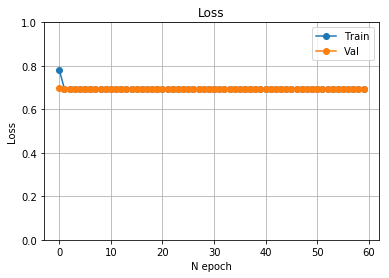

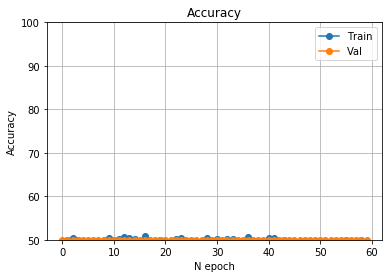

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False

plt.figure()
plt.ylim((0, 1))  
plt.plot(all_train_loss,marker='o', label="Train")
plt.plot(all_val_loss,marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend();

plt.figure()
plt.ylim((50, 100)) 
plt.plot(all_train_acc, marker='o', label="Train")
plt.plot(all_val_acc, marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)
plt.legend();
plt.show()


Check results

In [0]:
#bucle test
def test(model, loader):
    model.eval()
    loader = tqdm_notebook(loader, desc='MiniBatch: ')
    acc = AverageMeter()

    with torch.no_grad():
      for i, (img1, img2, gt) in enumerate(loader, start = 0):

            img1 =  img1.to('cuda:0')
            img2 = img2.to('cuda:0')
            gt = gt.long().to('cuda:0')
            
            batch_size = img1.size(0)

            outputs = model(img1, img2)

            acc.update(accuracy(outputs.data, gt)[0], batch_size)

            torch.cuda.empty_cache()
            
    return acc.avg





# cargamos el checkpoint con los mejores resultados en el modelo 
checkpoint = torch.load(check_point_name)


model.load_state_dict(checkpoint['model'])

# creamos dataset test
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
# esta petant el dataloader amb el dataset de TEST!! Us he posat el de validació per a que vegeu que el codi funciona però.. HEU D'ARREGLAR EL DATASET DE TEST, PQ AQUEST CODI HA DE FER SERVIR EL DATASET COMENTAT (EL DE TEST) 
datasetTest= CFPDataset(args.split_testdata, args, split="test", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
#datasetTest= CFPDataset(args.split_valdata, args, split="val", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
testloader = torch.utils.data.DataLoader(datasetTest, batch_size=bz ,shuffle=False, num_workers=4)

acc = test(model, testloader)

print("Test Accuracy: ", acc.item())


Dataset loaded
2800 samples in the test dataset



Test Accuracy:  50.0


# TEST 5: LR=5E-4, WD=0, N_EPOCHS=60 SIAMESE DECISION WITHOUT DATA AUGMENTATION WITH FREEZE

**1ST TUNING: LR=5E-4, WD=0, N_EPOCHS=60 SIAMESE DECISION WITHOUT DATA AUGMENTATION WITH FREEZE**

In [0]:
pretrained = True # Si ho poseu a false, entrenareu amb la xarxa init de forma random (Podeu fer l'experiment si voleu)
n_epochs = 60 # Número de epoques que voleu utilitzar

lr = 0.0005 # Podeu provar també amb 5e-4
betas = (0.9, 0.999) # No toqueu aquest paràmetre

wd = 0 # podeu utiltizar també 5e-4

bz = 16 # Poseu un batch size que no us desbordi la memòria

freezing=True #congelem layers

siamese_linear = False # Si poseu aquest valor a True, agafarà el model que en els features al final te una linear: SiameseDecisionLinear
data_aug = True # Si poseu aquest valor a True, us agafarà el transform amb data aumentation(podeu posar més transformacions si voleu jo solament he posat algunes d'exemple)


check_point_name = '/content/gdrive/My Drive/Colab Notebooks/weights/VGG PRETR1 LR5E-4 WD0 DA1 FREEZE/best_epoch.pth.tar' 
# aquest paràmetre l'heu de tunejar perquè no es sobreescriguin diferents experiments
# podeu posar els valors els paràmetres exemple:
# best_epoch_bz_32_wd_5e-4_lr_1e-3_nodata_aumentation
# IMPORTANT: AFEGIU AL PRINCIPI DEL NOM LA CARPETA ON VOLEU QUE ES GUARDI

In [0]:
# transforms per train i val dataset



# creem dataset train i val amb els seus respectius loaders
#datasetTrain = torchvision.datasets.CIFAR10('./cifar10/train', train=True, download=True, transform=transform)
args = Args()
train_transform=None
if data_aug == False:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

else:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.RandomHorizontalFlip(), 
                                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR), 
                                        transforms.ToTensor()])

    

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

datasetTrain = CFPDataset(args.split_traindata, args, split="train", img_transforms=train_transform, dataset_root=osp.expanduser(args.dataset_root))

datasetVal= CFPDataset(args.split_valdata, args, split="val", img_transforms=val_transform, dataset_root=osp.expanduser(args.dataset_root))                          
                         

trainloader = torch.utils.data.DataLoader(datasetTrain, batch_size=bz, shuffle=True, drop_last=True, num_workers=4)
valloader = torch.utils.data.DataLoader(datasetVal, batch_size=bz,shuffle=False, num_workers=4)


# creem la xarxa
if siamese_linear == False:
  print('SiameseDecision')
  model = SiameseDecision(pretrained=pretrained) 
else:
  print('SiameseLinearDecision')
  model = SiameseLinearDecision(pretrained=pretrained)
  
if freezing==True: 
    print("State of the features layers: \n")
    for name, child in model.feat.named_children():
      for name_2, params in child.named_parameters():
        print(child, name_2, params.requires_grad)
    nConv = 7 # Num de conv layers que queremos congelar
    features_freezed = 0
    for name, child in model.feat.named_children():
       if features_freezed < nConv:
        if isinstance(child,torch.nn.modules.conv.Conv2d): features_freezed+=1
        for name2, params in child.named_parameters():
          params.requires_grad = False

          model = model.to('cuda:0')

# creem la loss
loss_criterion = nn.CrossEntropyLoss()

# creem el optimitzador
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)



all_train_loss = []
all_train_acc = []


all_val_loss = []
all_val_acc = []

best_acc = -1
best_epoch = 0


for epoch in tqdm_notebook(range(n_epochs), desc='Epoch: '):  
  
    train_loss, train_acc, = train(model, trainloader, loss_criterion, optimizer)
    
    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)

                    
    print("Train Epoch: ",epoch, " Loss: ",train_loss, " Acc: ", train_acc)

    val_loss, val_acc = val(model, valloader, loss_criterion)
    
    
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)

    if best_acc < val_acc:
      best_acc = val_acc
      best_epoch = epoch
      
      checkpoint = {
          'epoch' : epoch,
          'model' : model.state_dict(),
          'acc' : best_acc,
      }
      torch.save(checkpoint, check_point_name) 
               
    print("Val Epoch: ",epoch, " Loss: ",val_loss, " Acc: ", val_acc)
    
    del val_loss, val_acc, train_loss, train_acc
    
print("Best Epoch: ",best_epoch, "Best Acc: ", best_acc)

Dataset loaded
8400 samples in the train dataset
Dataset loaded
2800 samples in the val dataset
SiameseDecision


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:09<00:00, 55899863.33it/s]


State of the features layers: 

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) weight True
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) bias True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) weight True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) bias True
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) weight True
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) bias True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) weight True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) bias True
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) weight True
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) bias True
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) weight True
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

Train Epoch:  0  Loss:  0.714435651188805  Acc:  50.2976188659668


Val Epoch:  0  Loss:  0.6959952143260411  Acc:  50.0


Train Epoch:  1  Loss:  0.693488400777181  Acc:  50.380950927734375


Val Epoch:  1  Loss:  0.6934599934305463  Acc:  50.0


Train Epoch:  2  Loss:  0.6934231043997265  Acc:  50.44047546386719


Val Epoch:  2  Loss:  0.6933063851084028  Acc:  50.0


Train Epoch:  3  Loss:  0.6564104345866612  Acc:  60.30952453613281


Val Epoch:  3  Loss:  0.5916925769192832  Acc:  68.03571319580078


Train Epoch:  4  Loss:  0.5741678805578323  Acc:  68.55952453613281


Val Epoch:  4  Loss:  0.5944537511893682  Acc:  68.78571319580078


Train Epoch:  5  Loss:  0.5609461994965871  Acc:  69.55952453613281


Val Epoch:  5  Loss:  0.5712989180428641  Acc:  69.07142639160156


Train Epoch:  6  Loss:  0.5500269256319319  Acc:  70.33333587646484


Val Epoch:  6  Loss:  0.5730948850086757  Acc:  69.42857360839844


Train Epoch:  7  Loss:  0.5428990343071165  Acc:  70.51190185546875


Val Epoch:  7  Loss:  0.5632546018702643  Acc:  70.67857360839844


Train Epoch:  8  Loss:  0.5358384792577653  Acc:  71.16666412353516


Val Epoch:  8  Loss:  0.5613422286510468  Acc:  70.60713958740234


Train Epoch:  9  Loss:  0.533844160976864  Acc:  71.28571319580078


Val Epoch:  9  Loss:  0.5637256584848677  Acc:  70.64285278320312


Train Epoch:  10  Loss:  0.5352976960227603  Acc:  70.75


Val Epoch:  10  Loss:  0.5599497078146254  Acc:  70.5


Train Epoch:  11  Loss:  0.5267926919460296  Acc:  71.45237731933594


Val Epoch:  11  Loss:  0.5606062863554273  Acc:  70.17857360839844


Train Epoch:  12  Loss:  0.5384970545768738  Acc:  70.76190185546875


Val Epoch:  12  Loss:  0.5690505255971636  Acc:  69.89285278320312


Train Epoch:  13  Loss:  0.5245142547289531  Acc:  71.86904907226562


Val Epoch:  13  Loss:  0.5748972405706133  Acc:  70.64285278320312


Train Epoch:  14  Loss:  0.523417723604611  Acc:  72.55952453613281


Val Epoch:  14  Loss:  0.6290953208718981  Acc:  69.25


Train Epoch:  15  Loss:  0.5275715871368136  Acc:  72.46428680419922


Val Epoch:  15  Loss:  0.550476154259273  Acc:  71.85713958740234


Train Epoch:  16  Loss:  0.5164797492822011  Acc:  73.20237731933594


Val Epoch:  16  Loss:  0.6246266818898065  Acc:  71.71428680419922


Train Epoch:  17  Loss:  0.526451383346603  Acc:  73.17857360839844


Val Epoch:  17  Loss:  0.6305203201941082  Acc:  70.17857360839844


Train Epoch:  18  Loss:  0.5092499260107676  Acc:  74.51190185546875


Val Epoch:  18  Loss:  0.5485737044470651  Acc:  71.10713958740234


Train Epoch:  19  Loss:  0.4899452441930771  Acc:  76.28571319580078


Val Epoch:  19  Loss:  0.5968981771809714  Acc:  73.5


Train Epoch:  20  Loss:  0.4830226683616638  Acc:  77.19047546386719


Val Epoch:  20  Loss:  0.5380581193310874  Acc:  74.0


Train Epoch:  21  Loss:  0.47169584776674  Acc:  77.5


Val Epoch:  21  Loss:  0.6071318390539714  Acc:  73.64285278320312


Train Epoch:  22  Loss:  0.4694390594107764  Acc:  77.86904907226562


Val Epoch:  22  Loss:  0.5323953995534352  Acc:  74.07142639160156


Train Epoch:  23  Loss:  0.4370537934700648  Acc:  79.51190185546875


Val Epoch:  23  Loss:  0.5389895520039967  Acc:  75.28571319580078


Train Epoch:  24  Loss:  0.432350427820569  Acc:  79.97618865966797


Val Epoch:  24  Loss:  0.5392443725892476  Acc:  76.96428680419922


Train Epoch:  25  Loss:  0.40898526633069626  Acc:  81.5952377319336


Val Epoch:  25  Loss:  0.565743179321289  Acc:  77.0


Train Epoch:  26  Loss:  0.3939997963678269  Acc:  82.5


Val Epoch:  26  Loss:  0.549684196795736  Acc:  76.07142639160156


Train Epoch:  27  Loss:  0.388682996176538  Acc:  82.8452377319336


Val Epoch:  27  Loss:  0.4999929089205606  Acc:  76.28571319580078


Train Epoch:  28  Loss:  0.3708114366304307  Acc:  83.63095092773438


Val Epoch:  28  Loss:  0.5252748764412744  Acc:  77.92857360839844


Train Epoch:  29  Loss:  0.359159489543665  Acc:  84.27381134033203


Val Epoch:  29  Loss:  0.48981548113482337  Acc:  78.75


Train Epoch:  30  Loss:  0.34739067128726414  Acc:  85.1547622680664


Val Epoch:  30  Loss:  0.48687809331076487  Acc:  79.03571319580078


Train Epoch:  31  Loss:  0.3350227338998091  Acc:  86.16666412353516


Val Epoch:  31  Loss:  0.47661071147237505  Acc:  78.35713958740234


Train Epoch:  32  Loss:  0.31952750457894236  Acc:  86.67857360839844


Val Epoch:  32  Loss:  0.4985422167607716  Acc:  80.39285278320312


Train Epoch:  33  Loss:  0.31881904145081835  Acc:  86.72618865966797


Val Epoch:  33  Loss:  0.5671346971392631  Acc:  79.53571319580078


Train Epoch:  34  Loss:  0.30586550167628695  Acc:  87.5952377319336


Val Epoch:  34  Loss:  0.5062580756417343  Acc:  79.07142639160156


Train Epoch:  35  Loss:  0.308754396800484  Acc:  87.27381134033203


Val Epoch:  35  Loss:  0.491269805261067  Acc:  80.53571319580078


Train Epoch:  36  Loss:  0.2922045716004712  Acc:  88.14285278320312


Val Epoch:  36  Loss:  0.4921379141722407  Acc:  79.57142639160156


Train Epoch:  37  Loss:  0.28351956543468293  Acc:  88.75


Val Epoch:  37  Loss:  0.5252868847761836  Acc:  79.25


Train Epoch:  38  Loss:  0.26549906500748227  Acc:  89.58333587646484


Val Epoch:  38  Loss:  0.5795872431567737  Acc:  79.57142639160156


Train Epoch:  39  Loss:  0.2662914174440361  Acc:  89.57142639160156


Val Epoch:  39  Loss:  0.5828729375771113  Acc:  79.82142639160156


Train Epoch:  40  Loss:  0.2589572665450119  Acc:  89.55952453613281


Val Epoch:  40  Loss:  0.5342330076864787  Acc:  79.64285278320312


Train Epoch:  41  Loss:  0.25046775602868626  Acc:  90.22618865966797


Val Epoch:  41  Loss:  0.5464426698003496  Acc:  79.75


Train Epoch:  42  Loss:  0.2495384239015125  Acc:  90.30952453613281


Val Epoch:  42  Loss:  0.5761631497314998  Acc:  79.17857360839844


Train Epoch:  43  Loss:  0.2343597451632931  Acc:  90.92857360839844


Val Epoch:  43  Loss:  0.5319242091264044  Acc:  80.14285278320312


Train Epoch:  44  Loss:  0.23564101654858816  Acc:  91.01190185546875


Val Epoch:  44  Loss:  0.5427738607994148  Acc:  79.82142639160156


Train Epoch:  45  Loss:  0.22641702380918322  Acc:  91.41666412353516


Val Epoch:  45  Loss:  0.5807174428658826  Acc:  80.46428680419922


Train Epoch:  46  Loss:  0.21980816345129695  Acc:  91.5952377319336


Val Epoch:  46  Loss:  0.5558961374419076  Acc:  79.85713958740234


Train Epoch:  47  Loss:  0.21909641563182786  Acc:  91.69047546386719


Val Epoch:  47  Loss:  0.5402548019800867  Acc:  80.03571319580078


Train Epoch:  48  Loss:  0.2021294053537505  Acc:  92.5


Val Epoch:  48  Loss:  0.6472454725418773  Acc:  79.21428680419922


Train Epoch:  49  Loss:  0.1980248391912097  Acc:  92.55952453613281


Val Epoch:  49  Loss:  0.6246024278870651  Acc:  78.46428680419922


Train Epoch:  50  Loss:  0.19919979715631123  Acc:  92.55952453613281


Val Epoch:  50  Loss:  0.5914311697866236  Acc:  79.07142639160156


Train Epoch:  51  Loss:  0.19278078963359196  Acc:  92.54761505126953


Val Epoch:  51  Loss:  0.6307947889396123  Acc:  80.21428680419922


Train Epoch:  52  Loss:  0.18563449727637427  Acc:  93.04761505126953


Val Epoch:  52  Loss:  0.6435677027276584  Acc:  79.39285278320312


Train Epoch:  53  Loss:  0.17930634036660195  Acc:  93.0952377319336


Val Epoch:  53  Loss:  0.6130471307784319  Acc:  79.25


Train Epoch:  54  Loss:  0.18091871771074478  Acc:  93.45237731933594


Val Epoch:  54  Loss:  0.6836463543772697  Acc:  79.07142639160156


Train Epoch:  55  Loss:  0.17721437212257157  Acc:  93.1547622680664


Val Epoch:  55  Loss:  0.5536714246017592  Acc:  80.78571319580078


Train Epoch:  56  Loss:  0.16513052851671264  Acc:  93.92857360839844


Val Epoch:  56  Loss:  0.6897085575972285  Acc:  81.03571319580078


Train Epoch:  57  Loss:  0.1714523142434302  Acc:  93.55952453613281


Val Epoch:  57  Loss:  0.6186653478017875  Acc:  80.14285278320312


Train Epoch:  58  Loss:  0.16476112238707996  Acc:  93.89285278320312


Val Epoch:  58  Loss:  0.647735294188772  Acc:  79.78571319580078


Train Epoch:  59  Loss:  0.15303418030341467  Acc:  94.28571319580078


Val Epoch:  59  Loss:  0.7650888917488711  Acc:  79.78571319580078

Best Epoch:  56 Best Acc:  81.03571319580078


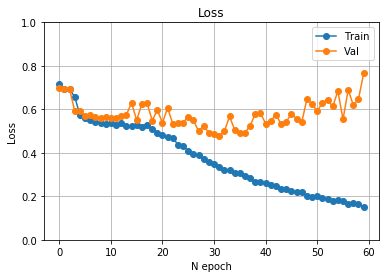

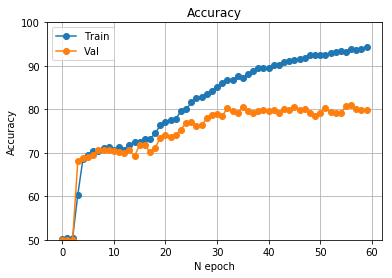

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False

plt.figure()
plt.ylim((0, 1))  
plt.plot(all_train_loss,marker='o', label="Train")
plt.plot(all_val_loss,marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend();

plt.figure()
plt.ylim((50, 100)) 
plt.plot(all_train_acc, marker='o', label="Train")
plt.plot(all_val_acc, marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)
plt.legend();
plt.show()


In [0]:
#bucle test
def test(model, loader):
    model.eval()
    loader = tqdm_notebook(loader, desc='MiniBatch: ')
    acc = AverageMeter()

    with torch.no_grad():
      for i, (img1, img2, gt) in enumerate(loader, start = 0):

            img1 =  img1.to('cuda:0')
            img2 = img2.to('cuda:0')
            gt = gt.long().to('cuda:0')
            
            batch_size = img1.size(0)

            outputs = model(img1, img2)

            acc.update(accuracy(outputs.data, gt)[0], batch_size)

            torch.cuda.empty_cache()
            
    return acc.avg





# cargamos el checkpoint con los mejores resultados en el modelo 
checkpoint = torch.load(check_point_name)


model.load_state_dict(checkpoint['model'])

# creamos dataset test
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
# esta petant el dataloader amb el dataset de TEST!! Us he posat el de validació per a que vegeu que el codi funciona però.. HEU D'ARREGLAR EL DATASET DE TEST, PQ AQUEST CODI HA DE FER SERVIR EL DATASET COMENTAT (EL DE TEST) 
datasetTest= CFPDataset(args.split_testdata, args, split="test", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
#datasetTest= CFPDataset(args.split_valdata, args, split="val", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
testloader = torch.utils.data.DataLoader(datasetTest, batch_size=bz ,shuffle=False, num_workers=4)

acc = test(model, testloader)

print("Test Accuracy: ", acc.item())

Dataset loaded
2800 samples in the test dataset



Test Accuracy:  79.46428680419922


# TEST 6: LR=1E-5, WD=0, N_EPOCHS=60 SIAMESE DECISION WITHOUT DATA AUGMENTATION WITH FREEZE

**1ST TUNING: LR=1E-5, WD=0, N_EPOCHS=60 SIAMESE DECISION WITHOUT DATA AUGMENTATION WITH FREEZE**

In [0]:
pretrained = True # Si ho poseu a false, entrenareu amb la xarxa init de forma random (Podeu fer l'experiment si voleu)
n_epochs = 60 # Número de epoques que voleu utilitzar

lr = 0.00001 # Podeu provar també amb 5e-4
betas = (0.9, 0.999) # No toqueu aquest paràmetre

wd = 0 # podeu utiltizar també 5e-4

bz = 16 # Poseu un batch size que no us desbordi la memòria

freezing=True #congelem layers

siamese_linear = False # Si poseu aquest valor a True, agafarà el model que en els features al final te una linear: SiameseDecisionLinear
data_aug = True # Si poseu aquest valor a True, us agafarà el transform amb data aumentation(podeu posar més transformacions si voleu jo solament he posat algunes d'exemple)


check_point_name = '/content/gdrive/My Drive/Colab Notebooks/weights/VGG PRETR1 LR1E-5 WD0 DA1 FREEZE/best_epoch.pth.tar' 
# aquest paràmetre l'heu de tunejar perquè no es sobreescriguin diferents experiments
# podeu posar els valors els paràmetres exemple:
# best_epoch_bz_32_wd_5e-4_lr_1e-3_nodata_aumentation
# IMPORTANT: AFEGIU AL PRINCIPI DEL NOM LA CARPETA ON VOLEU QUE ES GUARDI

In [0]:
# transforms per train i val dataset



# creem dataset train i val amb els seus respectius loaders
#datasetTrain = torchvision.datasets.CIFAR10('./cifar10/train', train=True, download=True, transform=transform)
args = Args()
train_transform=None
if data_aug == False:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

else:
  train_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.RandomHorizontalFlip(), 
                                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR), 
                                        transforms.ToTensor()])

    

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

datasetTrain = CFPDataset(args.split_traindata, args, split="train", img_transforms=train_transform, dataset_root=osp.expanduser(args.dataset_root))

datasetVal= CFPDataset(args.split_valdata, args, split="val", img_transforms=val_transform, dataset_root=osp.expanduser(args.dataset_root))                          
                         

trainloader = torch.utils.data.DataLoader(datasetTrain, batch_size=bz, shuffle=True, drop_last=True, num_workers=4)
valloader = torch.utils.data.DataLoader(datasetVal, batch_size=bz,shuffle=False, num_workers=4)


# creem la xarxa
if siamese_linear == False:
  print('SiameseDecision')
  model = SiameseDecision(pretrained=pretrained) 
else:
  print('SiameseLinearDecision')
  model = SiameseLinearDecision(pretrained=pretrained)
  
if freezing==True: 
    print("State of the features layers: \n")
    for name, child in model.feat.named_children():
      for name_2, params in child.named_parameters():
        print(child, name_2, params.requires_grad)
    nConv = 7 # Num de conv layers que queremos congelar
    features_freezed = 0
    for name, child in model.feat.named_children():
       if features_freezed < nConv:
        if isinstance(child,torch.nn.modules.conv.Conv2d): features_freezed+=1
        for name2, params in child.named_parameters():
          params.requires_grad = False

          model = model.to('cuda:0')

# creem la loss
loss_criterion = nn.CrossEntropyLoss()

# creem el optimitzador
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)



all_train_loss = []
all_train_acc = []


all_val_loss = []
all_val_acc = []

best_acc = -1
best_epoch = 0


for epoch in tqdm_notebook(range(n_epochs), desc='Epoch: '):  
  
    train_loss, train_acc, = train(model, trainloader, loss_criterion, optimizer)
    
    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)

                    
    print("Train Epoch: ",epoch, " Loss: ",train_loss, " Acc: ", train_acc)

    val_loss, val_acc = val(model, valloader, loss_criterion)
    
    
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)

    if best_acc < val_acc:
      best_acc = val_acc
      best_epoch = epoch
      
      checkpoint = {
          'epoch' : epoch,
          'model' : model.state_dict(),
          'acc' : best_acc,
      }
      torch.save(checkpoint, check_point_name) 
               
    print("Val Epoch: ",epoch, " Loss: ",val_loss, " Acc: ", val_acc)
    
    del val_loss, val_acc, train_loss, train_acc
    
print("Best Epoch: ",best_epoch, "Best Acc: ", best_acc)

Dataset loaded
8400 samples in the train dataset
Dataset loaded
2800 samples in the val dataset
SiameseDecision


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:05<00:00, 94432822.27it/s]


State of the features layers: 

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) weight True
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) bias True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) weight True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) bias True
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) weight True
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) bias True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) weight True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) bias True
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) weight True
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) bias True
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) weight True
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

Train Epoch:  0  Loss:  0.6968604083288283  Acc:  50.83333206176758


Val Epoch:  0  Loss:  0.6968525971685137  Acc:  50.0


Train Epoch:  1  Loss:  0.6444724601791019  Acc:  60.130950927734375


Val Epoch:  1  Loss:  0.5919770802344595  Acc:  70.07142639160156


Train Epoch:  2  Loss:  0.537177856252307  Acc:  71.69047546386719


Val Epoch:  2  Loss:  0.5432288443616459  Acc:  73.39285278320312


Train Epoch:  3  Loss:  0.4623830270199549  Acc:  77.64285278320312


Val Epoch:  3  Loss:  0.5238951742436204  Acc:  75.64285278320312


Train Epoch:  4  Loss:  0.39338010699976056  Acc:  82.41666412353516


Val Epoch:  4  Loss:  0.5079829286677496  Acc:  78.96428680419922


Train Epoch:  5  Loss:  0.3427440313356263  Acc:  85.02381134033203


Val Epoch:  5  Loss:  0.49580558204225134  Acc:  77.53571319580078


Train Epoch:  6  Loss:  0.3023764311912514  Acc:  87.21428680419922


Val Epoch:  6  Loss:  0.5382397789827414  Acc:  79.96428680419922


Train Epoch:  7  Loss:  0.26537231890928176  Acc:  89.07142639160156


Val Epoch:  7  Loss:  0.5375094256443637  Acc:  78.92857360839844


Train Epoch:  8  Loss:  0.2378011703491211  Acc:  90.28571319580078


Val Epoch:  8  Loss:  0.5818165092170239  Acc:  79.64285278320312


Train Epoch:  9  Loss:  0.20582847673978125  Acc:  91.75


Val Epoch:  9  Loss:  0.6086816690649305  Acc:  79.57142639160156


Train Epoch:  10  Loss:  0.18619139003611745  Acc:  92.51190185546875


Val Epoch:  10  Loss:  0.5761077031493187  Acc:  79.92857360839844


Train Epoch:  11  Loss:  0.16361453362164044  Acc:  93.42857360839844


Val Epoch:  11  Loss:  0.6186796054882663  Acc:  79.67857360839844


Train Epoch:  12  Loss:  0.15637943813133806  Acc:  93.5952377319336


Val Epoch:  12  Loss:  0.6542599232069084  Acc:  80.5


Train Epoch:  13  Loss:  0.14321405929114137  Acc:  94.4047622680664


Val Epoch:  13  Loss:  0.6394211300994669  Acc:  80.32142639160156


Train Epoch:  14  Loss:  0.12681590683403468  Acc:  95.0


Val Epoch:  14  Loss:  0.6637280880340508  Acc:  78.89285278320312


Train Epoch:  15  Loss:  0.11463923454639457  Acc:  95.61904907226562


Val Epoch:  15  Loss:  0.7114241319575481  Acc:  80.42857360839844


Train Epoch:  16  Loss:  0.10566782509996778  Acc:  95.95237731933594


Val Epoch:  16  Loss:  0.7480158697920186  Acc:  79.35713958740234


Train Epoch:  17  Loss:  0.09846685340007146  Acc:  96.4047622680664


Val Epoch:  17  Loss:  0.7505492182075977  Acc:  79.92857360839844


Train Epoch:  18  Loss:  0.08436720891722611  Acc:  96.73809051513672


Val Epoch:  18  Loss:  0.7751155676799161  Acc:  79.75


Train Epoch:  19  Loss:  0.0871003302506038  Acc:  96.55952453613281


Val Epoch:  19  Loss:  0.8509467024036816  Acc:  80.96428680419922


Train Epoch:  20  Loss:  0.07246774562057995  Acc:  97.30952453613281


Val Epoch:  20  Loss:  0.8092486097982952  Acc:  79.89285278320312


Train Epoch:  21  Loss:  0.07306403697246597  Acc:  97.25


Val Epoch:  21  Loss:  0.8781281870071377  Acc:  80.39285278320312


Train Epoch:  22  Loss:  0.06629048277934392  Acc:  97.55952453613281


Val Epoch:  22  Loss:  0.9433746346618448  Acc:  80.35713958740234


Train Epoch:  23  Loss:  0.06110901071202187  Acc:  97.66666412353516


Val Epoch:  23  Loss:  0.8576109018389668  Acc:  79.64285278320312


Train Epoch:  24  Loss:  0.059414576490720114  Acc:  97.8452377319336


Val Epoch:  24  Loss:  0.9634714153302567  Acc:  80.89285278320312


Train Epoch:  25  Loss:  0.05523437489711103  Acc:  98.03571319580078


Val Epoch:  25  Loss:  0.9347402484821422  Acc:  81.10713958740234


Train Epoch:  26  Loss:  0.05680379318694274  Acc:  97.98809051513672


Val Epoch:  26  Loss:  0.9336578752526216  Acc:  81.14285278320312


Train Epoch:  27  Loss:  0.04941476893212114  Acc:  98.10713958740234


Val Epoch:  27  Loss:  0.9874336489289999  Acc:  80.21428680419922


Train Epoch:  28  Loss:  0.05315504202707892  Acc:  98.02381134033203


Val Epoch:  28  Loss:  1.0247607971089228  Acc:  80.75


Train Epoch:  29  Loss:  0.04570082809953462  Acc:  98.39285278320312


Val Epoch:  29  Loss:  0.991192867681384  Acc:  81.28571319580078


Train Epoch:  30  Loss:  0.05193970347799006  Acc:  98.16666412353516


Val Epoch:  30  Loss:  0.9015664397286517  Acc:  80.75


Train Epoch:  31  Loss:  0.040687122341422806  Acc:  98.61904907226562


Val Epoch:  31  Loss:  0.9662557691016368  Acc:  80.92857360839844


Train Epoch:  32  Loss:  0.044537967894048916  Acc:  98.52381134033203


Val Epoch:  32  Loss:  0.972479989326426  Acc:  81.10713958740234


Train Epoch:  33  Loss:  0.037964396657688276  Acc:  98.63095092773438


Val Epoch:  33  Loss:  1.0440235634786743  Acc:  81.17857360839844


Train Epoch:  34  Loss:  0.037864544380988394  Acc:  98.63095092773438


Val Epoch:  34  Loss:  1.0454866665388856  Acc:  80.35713958740234


Train Epoch:  35  Loss:  0.0364489923559484  Acc:  98.6547622680664


Val Epoch:  35  Loss:  1.0235573148940291  Acc:  81.78571319580078


Train Epoch:  36  Loss:  0.036599359441371195  Acc:  98.76190185546875


Val Epoch:  36  Loss:  1.0423929856717586  Acc:  81.28571319580078


Train Epoch:  37  Loss:  0.03272997257255372  Acc:  98.89285278320312


Val Epoch:  37  Loss:  1.0179993047352347  Acc:  81.32142639160156


Train Epoch:  38  Loss:  0.03113603124661105  Acc:  98.95237731933594


Val Epoch:  38  Loss:  1.0151916366922005  Acc:  81.67857360839844


Train Epoch:  39  Loss:  0.03812269464844749  Acc:  98.77381134033203


Val Epoch:  39  Loss:  1.0523182422348432  Acc:  81.82142639160156


Train Epoch:  40  Loss:  0.025802406987973623  Acc:  99.17857360839844


Val Epoch:  40  Loss:  1.1335512747934886  Acc:  81.42857360839844


Train Epoch:  41  Loss:  0.029262408348066465  Acc:  98.9047622680664


Val Epoch:  41  Loss:  1.0758544131900583  Acc:  82.17857360839844


Train Epoch:  42  Loss:  0.03305505934925306  Acc:  98.79761505126953


Val Epoch:  42  Loss:  1.0200355001538992  Acc:  82.0


Train Epoch:  43  Loss:  0.028148366177365894  Acc:  98.95237731933594


Val Epoch:  43  Loss:  1.0664755036149707  Acc:  81.64285278320312


Train Epoch:  44  Loss:  0.023539879311408315  Acc:  99.22618865966797


Val Epoch:  44  Loss:  1.1125813102935043  Acc:  81.35713958740234


Train Epoch:  45  Loss:  0.020948672624570983  Acc:  99.36904907226562


Val Epoch:  45  Loss:  1.3669639453824078  Acc:  81.39285278320312


Train Epoch:  46  Loss:  0.020177309818211055  Acc:  99.25


Val Epoch:  46  Loss:  1.2387837624762739  Acc:  81.28571319580078


Train Epoch:  47  Loss:  0.025984160030881564  Acc:  99.17857360839844


Val Epoch:  47  Loss:  1.2821102256753616  Acc:  81.0


Train Epoch:  48  Loss:  0.02662846860786279  Acc:  99.13095092773438


Val Epoch:  48  Loss:  1.1430512247553895  Acc:  81.32142639160156


Train Epoch:  49  Loss:  0.02256749974120231  Acc:  99.16666412353516


Val Epoch:  49  Loss:  1.137721630781889  Acc:  80.96428680419922


Train Epoch:  50  Loss:  0.026504291590480577  Acc:  99.14285278320312


Val Epoch:  50  Loss:  1.1368566818641765  Acc:  81.35713958740234


Train Epoch:  51  Loss:  0.022083405823934647  Acc:  99.30952453613281


Val Epoch:  51  Loss:  1.3615063436967987  Acc:  81.14285278320312


Train Epoch:  52  Loss:  0.023653350238289152  Acc:  99.22618865966797


Val Epoch:  52  Loss:  1.1060856968164443  Acc:  81.5


Train Epoch:  53  Loss:  0.01917302213254429  Acc:  99.33333587646484


Val Epoch:  53  Loss:  1.3105263087153434  Acc:  81.5


Train Epoch:  54  Loss:  0.018777067530013267  Acc:  99.22618865966797


Val Epoch:  54  Loss:  1.2896311031281948  Acc:  81.60713958740234


Train Epoch:  55  Loss:  0.018321455032342955  Acc:  99.28571319580078


Val Epoch:  55  Loss:  1.2300763700902462  Acc:  82.67857360839844


Train Epoch:  56  Loss:  0.022802757663386207  Acc:  99.29761505126953


Val Epoch:  56  Loss:  1.155996065320713  Acc:  81.71428680419922


Train Epoch:  57  Loss:  0.018604257979563305  Acc:  99.39285278320312


Val Epoch:  57  Loss:  1.1791174145681518  Acc:  82.07142639160156


Train Epoch:  58  Loss:  0.020037658924148195  Acc:  99.39285278320312


Val Epoch:  58  Loss:  1.38590844870678  Acc:  81.32142639160156


Train Epoch:  59  Loss:  0.017743862842520077  Acc:  99.39285278320312


Val Epoch:  59  Loss:  1.2512489587281432  Acc:  81.67857360839844

Best Epoch:  55 Best Acc:  82.67857360839844


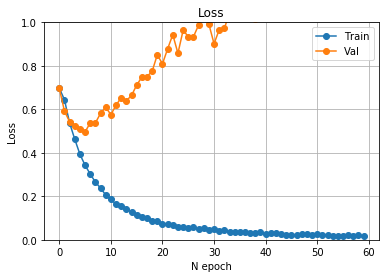

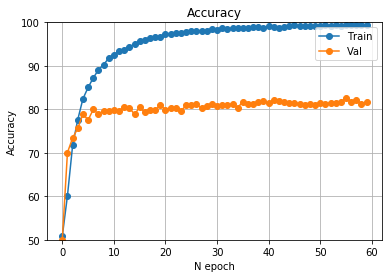

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False

plt.figure()
plt.ylim((0, 1))  
plt.plot(all_train_loss,marker='o', label="Train")
plt.plot(all_val_loss,marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend();

plt.figure()
plt.ylim((50, 100)) 
plt.plot(all_train_acc, marker='o', label="Train")
plt.plot(all_val_acc, marker='o', label="Val")
plt.xlabel("N epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)
plt.legend();
plt.show()


In [0]:
#bucle test
def test(model, loader):
    model.eval()
    loader = tqdm_notebook(loader, desc='MiniBatch: ')
    acc = AverageMeter()

    with torch.no_grad():
      for i, (img1, img2, gt) in enumerate(loader, start = 0):

            img1 =  img1.to('cuda:0')
            img2 = img2.to('cuda:0')
            gt = gt.long().to('cuda:0')
            
            batch_size = img1.size(0)

            outputs = model(img1, img2)

            acc.update(accuracy(outputs.data, gt)[0], batch_size)

            torch.cuda.empty_cache()
            
    return acc.avg





# cargamos el checkpoint con los mejores resultados en el modelo 
checkpoint = torch.load(check_point_name)


model.load_state_dict(checkpoint['model'])

# creamos dataset test
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
# esta petant el dataloader amb el dataset de TEST!! Us he posat el de validació per a que vegeu que el codi funciona però.. HEU D'ARREGLAR EL DATASET DE TEST, PQ AQUEST CODI HA DE FER SERVIR EL DATASET COMENTAT (EL DE TEST) 
datasetTest= CFPDataset(args.split_testdata, args, split="test", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
#datasetTest= CFPDataset(args.split_valdata, args, split="val", img_transforms=transform, dataset_root=osp.expanduser(args.dataset_root))                           
testloader = torch.utils.data.DataLoader(datasetTest, batch_size=bz ,shuffle=False, num_workers=4)

acc = test(model, testloader)

print("Test Accuracy: ", acc.item())

Dataset loaded
2800 samples in the test dataset



Test Accuracy:  82.89285278320312


In [0]:
 BEST OPTION IS TEST 2   1ST TUNING: LR=1E-3, WD=0, N_EPOCHS=60 SIAMESE DECISION WITH DATA AUGMENTATION